In [7]:
import tensorflow as tf
from gnn_src_code import GNN_double_output
import compgraph
import networkx as nx
from compgraph.useful import sites_to_sparse, neel_state
from simulation.initializer import create_graph_from_ham
import quimb as qu

lattice_size = (2, 2)
sublattice_encoding = neel_state(nx.grid_2d_graph(*lattice_size, periodic=True)) 
G,subl=create_graph_from_ham(geometric_structure="2dsquare", lattice_size=lattice_size, sublattice='Neel')

In [6]:
from compgraph.training import outer_training
from simulation.initializer import create_graph_from_ham, initialize_NQS_model_fromhyperparams, initialize_hamiltonian_and_groundstate, initialize_graph_tuples
import numpy as np
from compgraph.useful import create_graph_tuples

hyperparams = {
    'graph_params':{
    'graphType': '2dsquare',
    'n': 2,
    'm': 2,
    'sublattice':'Neel'
    },
    'sim_params':{
    'beta': 0.05,
    'batch_size': 4,
    'learning_rate': 7e-5,
    'n_batch': 1,
    }
    ,
    'ansatz': 'GNN2adv',
    'ansatz_params': {
        'K_layer':1,
        'hidden_size': 8,
        'output_emb_size': 4
    }
}
graph, subl = create_graph_from_ham(
    hyperparams['graph_params']['graphType'],
    (hyperparams['graph_params']['n'], hyperparams['graph_params']['m']),
    hyperparams['graph_params']['sublattice']
)

full_basis_configs = np.array([[int(x) for x in format(i, f'0{len(graph.nodes)}b')] for i in range(2**(len(graph.nodes)))]) * 2 - 1

full_basis_gt=create_graph_tuples(full_basis_configs, graph,subl)

# Generate the full basis configurations for the system
lowest_eigenstate_as_sparse = initialize_hamiltonian_and_groundstate(hyperparams['graph_params'], full_basis_configs)

# Initialize the variational and fixed models
model_w = initialize_NQS_model_fromhyperparams(hyperparams['ansatz'], hyperparams['ansatz_params'])
model_fix = initialize_NQS_model_fromhyperparams(hyperparams['ansatz'], hyperparams['ansatz_params'])

# Generate tuples of graphs for variational training and fixed comparisons
graph_tuples_var = initialize_graph_tuples(
    hyperparams['sim_params']['n_batch'] * hyperparams['sim_params']['batch_size'],
    graph, subl)
graph_tuples_fix = initialize_graph_tuples(
    hyperparams['sim_params']['n_batch'] * hyperparams['sim_params']['batch_size'],
    graph, subl)


In [9]:
def finite_difference_gradients_complex(func, vars, epsilon=1e-5):
    """
    Compute finite difference approximation of gradients for complex-valued functions.
    
    Args:
    func: Function to compute the complex-valued loss.
    vars: List of variables to compute the gradients with respect to.
    epsilon: Small perturbation value for finite difference computation.
    
    Returns:
    List of finite difference gradients (real and imaginary parts separately).
    """
    finite_diffs = []

    for var in vars:
        grad_approx = np.zeros_like(var.numpy(), dtype=np.float64)
        var_value = var.numpy()

        # Iterate over each element of the variable
        for index in np.ndindex(var_value.shape):
            original_value = var_value[index]

            # Perturb the variable positively in real part
            var_value[index] = original_value + epsilon
            var.assign(var_value)
            loss_plus = func()

            # Perturb the variable negatively in real part
            var_value[index] = original_value - epsilon
            var.assign(var_value)
            loss_minus = func()

            # Reset the variable to original value
            var_value[index] = original_value
            var.assign(var_value)

            # Finite difference gradient approximation for real part
            grad_approx[index] = (loss_plus - loss_minus)/ (2 * epsilon)

        finite_diffs.append(grad_approx)

    return finite_diffs
def finite_diff_confrontation(sampler_var, sampler_te, graph_batch_var,graph_batch_te, coeff_te_on_te):
    
    with tf.GradientTape() as tape:
        
        # model_var=sampler_var.model
        tape.watch(sampler_var.model.trainable_variables)

        coeff_var_on_var=[sampler_var.evaluate_model(graph_tuple) for graph_tuple in graph_batch_var]    
        #print("output: \n", output)
        n_sites=len(graph_batch_var[0].nodes[:,0])
        wave_function_var_on_var, freq_var =create_amplitude_frequencies_from_graph_tuples(graph_batch_var, coeff_var_on_var)
        unique_tuples_var=generate_graph_tuples_configs(graph_batch_var[0],sparse_list_to_configs(freq_var.indices[:, 0],n_sites),subl)
        wave_function_te_on_te, freq_te= create_amplitude_frequencies_from_graph_tuples(graph_batch_te, coeff_te_on_te)
        unique_tuples_te=generate_graph_tuples_configs(graph_batch_var[0],sparse_list_to_configs(freq_te.indices[:, 0],n_sites),subl)
        
        coeff_te_on_var=[sampler_te.time_evoluted_config_amplitude(graph_tuple) for graph_tuple in unique_tuples_var]        

        coeff_var_on_te=[sampler_var.evaluate_model(graph_tuple) for graph_tuple in unique_tuples_te]
        
        wave_function_var_on_te, _=create_amplitude_frequencies_from_graph_tuples(unique_tuples_te, coeff_var_on_te)
        wave_function_te_on_var, _= create_amplitude_frequencies_from_graph_tuples(unique_tuples_var, coeff_te_on_var)
        # Convert freq_var to complex if it's not already complex
        freq_var = tf.cast(freq_var.values, dtype=tf.complex128)
        freq_te = tf.cast(freq_te.values, dtype=tf.complex128)
        ratios_var=freq_var*(wave_function_te_on_var.values)/(wave_function_var_on_var.values)

        ratios_te = freq_te * tf.math.conj(wave_function_var_on_te.values) / tf.math.conj(wave_function_te_on_te.values)
        
        # All the operations from your existing code go here...

        # Compute the overlap
        overlap = tf.reduce_sum(ratios_var) * tf.reduce_sum(ratios_te)
        log_overlap = tf.math.log(overlap)
        loss = -log_overlap
    
    # Calculate gradients using TensorFlow
    gradients = tape.gradient(loss, sampler_var.model.trainable_variables)
    print("Analytical graidents", gradients)
    # Function to compute the loss for finite difference gradient approximation
    def compute_loss():
        # Recalculate the loss based on the current state of variables
        with tf.GradientTape() as inner_tape:
            overlap = tf.reduce_sum(ratios_var) * tf.reduce_sum(ratios_te)
            log_overlap = tf.math.log(overlap)
            return -log_overlap
    
    # Calculate finite difference gradients
    finite_diffs = finite_difference_gradients_complex(compute_loss, sampler_var.model.trainable_variables)
    
    # Compare analytical gradients with finite difference gradients
    for grad, fd_grad in zip(gradients, finite_diffs):
        if np.allclose(grad.numpy(), fd_grad, atol=1e-4):
            print("Gradient check passed!")
        else:
            print("Gradient check failed!")
            print("Analytical Gradient: \n", grad.numpy())
            print("Finite Difference Gradient: \n", fd_grad)
    
    # optimizer.apply_gradients(zip(gradients, sampler_var.model.trainable_variables))
    return wave_function_var_on_var, loss


In [10]:
from monte_carlo import MCMCSampler
import monte_carlo
import importlib
importlib.reload(monte_carlo)
from monte_carlo import MCMCSampler
hyperparams = {
    'graph_params':{
    'graphType': '2dsquare',
    'n': 2,
    'm': 2,
    'sublattice':'Neel'
    },
    'sim_params':{
    'beta': 0.05,
    'full_size_hilbert': 'no',
    'batch_size': 32,
    'learning_rate': 7e-5,
    'outer_loop':20,
    'inner_loop': 3,
    'n_batch': 1,
    }
    ,
    'ansatz': 'GNN2simple',
    'ansatz_params': {
        
        'hidden_size': 128,
        'output_emb_size': 32
    }
}
graph, subl=create_graph_from_ham(hyperparams['graph_params']['graphType'], (hyperparams['graph_params']['n'],hyperparams['graph_params']['m']), hyperparams['graph_params']['sublattice'] )
print(graph.nodes, graph.edges[(1,0)]['features'], graph.nodes[3])
full_basis_configs = np.array([[int(x) for x in format(i, f'0{len(graph.nodes)}b')] for i in range(2**(len(graph.nodes)))]) * 2 - 1

low_eg_asp=initialize_hamiltonian_and_groundstate(hyperparams['graph_params'], full_basis_configs)
model_w=initialize_NQS_model_fromhyperparams(hyperparams['ansatz'], hyperparams['ansatz_params'])
model_fix=initialize_NQS_model_fromhyperparams(hyperparams['ansatz'], hyperparams['ansatz_params'])
N_sweeps=1




[0, 1, 2, 3] [1.0] {'features': array([0., 1.])}


In [13]:
import compgraph.monte_carlo
from compgraph.useful import create_graph_tuples
import compgraph.useful
import importlib
importlib.reload(compgraph.monte_carlo)
from compgraph.monte_carlo import MCMCSampler
importlib.reload(compgraph.useful)
from compgraph.useful import create_graph_tuples
from compgraph.cg_repr import graph_tuple_to_config_hamiltonian_product_update
sampler_te = MCMCSampler(model_fix, graph_tuples_fix[0], 0.05, graph, subl)

unique_tuples_te, coeff_te_on_te  = zip(*[sampler_te.monte_carlo_update(N_sweeps, graph_tuple, 'te') for graph_tuple in full_basis_gt])

sampler_var = MCMCSampler(model_w, graph_tuples_var[0])
unique_tuples_var, coeff_var_on_var = zip(*[sampler_var.monte_carlo_update(N_sweeps, graph_tuple,'var') for graph_tuple in full_basis_gt])
coeff_te_on_var= [sampler_te.evaluate_model(graph_tuple) for graph_tuple in full_basis_gt]
coeff_var_on_var=[sampler_var.evaluate_model(graph_tuple) for graph_tuple in full_basis_gt]
coeff_var_on_var, coeff_te_on_var
full_basis_configs = np.array([[int(x) for x in format(i, f'0{len(graph.nodes)}b')] for i in range(2**(len(graph.nodes)))]) * 2 - 1

full_basis_gt=create_graph_tuples(full_basis_configs, graph,subl)
sampler_te.update_model(sampler_var.model)
wave_function_te_on_full=[sampler_te.time_evoluted_config_amplitude(graph_tuple) for graph_tuple in full_basis_gt]

wave_function_var_on_full=[sampler_var.model(graph_tuple) for graph_tuple in full_basis_gt]
coeff_var_on_var, '\n', wave_function_te_on_full


([<tf.Tensor: shape=(), dtype=complex128, numpy=(0.9355696827200943+5.943552715914831j)>,
  <tf.Tensor: shape=(), dtype=complex128, numpy=(1.0288995279432807-3.110656481920992j)>,
  <tf.Tensor: shape=(), dtype=complex128, numpy=(0.3467687495143052+4.863378722806471j)>,
  <tf.Tensor: shape=(), dtype=complex128, numpy=(2.9892674161977872-1.2439590301327044j)>,
  <tf.Tensor: shape=(), dtype=complex128, numpy=(1.028899527943278-3.110656481920994j)>,
  <tf.Tensor: shape=(), dtype=complex128, numpy=(0.36003438508959384-1.531460851543544j)>,
  <tf.Tensor: shape=(), dtype=complex128, numpy=(2.4527948264900092-0.5482622559066569j)>,
  <tf.Tensor: shape=(), dtype=complex128, numpy=(2.0018749472441595-0.766673123031315j)>,
  <tf.Tensor: shape=(), dtype=complex128, numpy=(0.34676874951430536+4.863378722806472j)>,
  <tf.Tensor: shape=(), dtype=complex128, numpy=(2.4527948264900084-0.5482622559066567j)>,
  <tf.Tensor: shape=(), dtype=complex128, numpy=(0.16953180649368255+1.682209998226976j)>,
  <tf

In [16]:
from compgraph.useful import create_amplitude_frequencies_from_graph_tuples, generate_graph_tuples_configs, sparse_list_to_configs
with tf.GradientTape() as tape:
    
    # model_var=sampler_var.model
    tape.watch(sampler_var.model.trainable_variables)

    coeff_var_on_var=[sampler_var.evaluate_model(graph_tuple) for graph_tuple in graph_tuples_var]    
    #print("output: \n", output)
    n_sites=len(graph_tuples_var[0].nodes[:,0])
    wave_function_var_on_var, freq_var =create_amplitude_frequencies_from_graph_tuples(graph_tuples_var, coeff_var_on_var)
    unique_tuples_var=generate_graph_tuples_configs(graph_tuples_var[0],sparse_list_to_configs(freq_var.indices[:, 0],n_sites))
    wave_function_te_on_te, freq_te= create_amplitude_frequencies_from_graph_tuples(graph_tuples_fix, coeff_te_on_te)
    unique_tuples_te=generate_graph_tuples_configs(graph_tuples_var[0],sparse_list_to_configs(freq_te.indices[:, 0],n_sites))
    
    coeff_te_on_var=[sampler_te.time_evoluted_config_amplitude(graph_tuple) for graph_tuple in unique_tuples_var]        

    coeff_var_on_te=[sampler_var.evaluate_model(graph_tuple) for graph_tuple in unique_tuples_te]
    print(coeff_var_on_var,'\n',coeff_te_on_var)
    print(coeff_te_on_te,'\n',coeff_var_on_te)
    wave_function_var_on_te, _=create_amplitude_frequencies_from_graph_tuples(unique_tuples_te, coeff_var_on_te)
    wave_function_te_on_var, _= create_amplitude_frequencies_from_graph_tuples(unique_tuples_var, coeff_te_on_var)
    # Convert freq_var to complex if it's not already complex
    freq_var = tf.cast(freq_var.values, dtype=tf.complex128)
    freq_te = tf.cast(freq_te.values, dtype=tf.complex128)
    ratios_var=freq_var*(wave_function_te_on_var.values)/(wave_function_var_on_var.values)

    ratios_te = freq_te * tf.math.conj(wave_function_var_on_te.values) / tf.math.conj(wave_function_te_on_te.values)
    
    # Compute the overlap
    overlap = tf.reduce_sum(tf.abs(ratios_var))* tf.reduce_sum(tf.abs(ratios_te))
    
    # Calculate the negative log of the overlap
    log_overlap = tf.math.log((overlap))
    
    loss= -log_overlap  
    

[<tf.Tensor: shape=(), dtype=complex128, numpy=(2.0018749472441586-0.7666731230313167j)>, <tf.Tensor: shape=(), dtype=complex128, numpy=(1.028899527943278-3.110656481920994j)>, <tf.Tensor: shape=(), dtype=complex128, numpy=(2.4527948264900092-0.5482622559066569j)>, <tf.Tensor: shape=(), dtype=complex128, numpy=(0.36003438508959384-1.531460851543544j)>] 
 [<tf.Tensor: shape=(), dtype=complex128, numpy=(0.9601161140703987-3.198292593965268j)>, <tf.Tensor: shape=(), dtype=complex128, numpy=(0.11475490244059294-1.4766346259528782j)>, <tf.Tensor: shape=(), dtype=complex128, numpy=(2.3726692579400677-0.4862300358182238j)>, <tf.Tensor: shape=(), dtype=complex128, numpy=(1.8469543396401984-0.7261504159028077j)>]
(<tf.Tensor: shape=(), dtype=complex128, numpy=(0.2779853356414262+4.775742610762198j)>, <tf.Tensor: shape=(), dtype=complex128, numpy=(2.3726692579400663-0.4862300358182236j)>, <tf.Tensor: shape=(), dtype=complex128, numpy=(0.2779853356414259+4.7757426107621965j)>, <tf.Tensor: shape=(

In [17]:
import importlib
import compgraph.gnn_src_code
from compgraph.gnn_src_code import GNN_double_output

importlib.reload(compgraph.gnn_src_code)
from compgraph.gnn_src_code import GNN_double_output

beta=0.12
model=GNN_double_output(tf.constant(64),8)

sampler_te = MCMCSampler(model, full_basis_gt[0], beta, graph, subl)
print(sampler_te.model(full_basis_gt[-1])[0], sampler_te.evaluate_model(full_basis_gt[-1]))

for i in range(8):
    print(sampler_te.model(full_basis_gt[i])[0], sampler_te.evaluate_model(full_basis_gt[i]))
    # wave_function_te_on_full=[sampler_te.evaluate_model(graph_tuple) for graph_tuple in full_basis_gt]
    # print(wave_function_te_on_full)


tf.Tensor([7.17402952 6.04188699], shape=(2,), dtype=float64) tf.Tensor((6.966187431102689-1.7143314222218071j), shape=(), dtype=complex128)
tf.Tensor([-0.94658516  0.53008931], shape=(2,), dtype=float64) tf.Tensor((-0.8166776295662612-0.4786033042556298j), shape=(), dtype=complex128)
tf.Tensor([0.6366967  2.10228789], shape=(2,), dtype=float64) tf.Tensor((-0.3226904372056127+0.5488657152442757j), shape=(), dtype=complex128)
tf.Tensor([-0.66559853  0.04007981], shape=(2,), dtype=float64) tf.Tensor((-0.6650639968890549-0.026669921250852914j), shape=(), dtype=complex128)
tf.Tensor([2.23799293 2.10518186], shape=(2,), dtype=float64) tf.Tensor((-1.1398374083420677+1.9259758699930436j), shape=(), dtype=complex128)
tf.Tensor([0.6366967  2.10228789], shape=(2,), dtype=float64) tf.Tensor((-0.32269043720561186+0.5488657152442754j), shape=(), dtype=complex128)
tf.Tensor([3.45776389 3.55185215], shape=(2,), dtype=float64) tf.Tensor((-3.1708294919346063-1.3791197984298325j), shape=(), dtype=comple

# Test for checking ITE is the same as psi - beta*H psi what is expected.

In [5]:
from monte_carlo import MCMCSampler
from compgraph.useful import create_graph_tuples, config_to_state, state_from_config_amplitudes
from compgraph.training import outer_training
from simulation.initializer import create_graph_from_ham, initialize_NQS_model_fromhyperparams, initialize_hamiltonian_and_groundstate, initialize_graph_tuples
import numpy as np
from compgraph.useful import create_graph_tuples

hyperparams = {
    'graph_params':{
    'graphType': '2dsquare',
    'n': 3,
    'm': 3,
    'sublattice':'Neel'
    }
}
graph, subl = create_graph_from_ham(
    hyperparams['graph_params']['graphType'],
    (hyperparams['graph_params']['n'], hyperparams['graph_params']['m']),
    hyperparams['graph_params']['sublattice']
)
full_basis_configs = np.array([[int(x) for x in format(i, f'0{len(graph.nodes)}b')] for i in range(2**(len(graph.nodes)))]) * 2 - 1

full_basis_gt=create_graph_tuples(full_basis_configs, graph,subl)
model=GNN_double_output(64,64)

N_sweeps=1
beta=0.15
n,m=(hyperparams['graph_params']['n'],hyperparams['graph_params']['m'])
sampler_te = MCMCSampler(model, full_basis_gt[0], beta, graph)

wave_function_te_on_full=[sampler_te.evaluate_model(graph_tuple) for graph_tuple in full_basis_gt]
# wave_function_te_on_full=[sampler_te.evaluate_model(graph_tuple) for graph_tuple in full_basis_gt]

# print(wave_function_te_on_full)

Hamiltonian= qu.ham_heis_2D(n, m, j=1.0, bz=0, cyclic=True, parallel=False, ownership=None)

# Compute the wavefunction coefficient using your routine

# Convert the computed coefficients to a quimb vector
# The coefficients should be arranged in the correct basis order for quimb
amplitudes =np.array(wave_function_te_on_full)

psi_full_state_vec=state_from_config_amplitudes(full_basis_configs,amplitudes)
H_psi_beta= beta* Hamiltonian @ psi_full_state_vec

for index, gt in enumerate(full_basis_gt):
    total_amplitude = sampler_te.time_evoluted_config_amplitude(gt)

    psi_amplitude=sampler_te.evaluate_model(gt)
    # print(sampler_te.model(gt),sampler_te.evaluate_model(gt))
    # print(psi_amplitude)   
    # print(gt)
    psi_ket= config_to_state(full_basis_configs[index])  # Convert config to corresponding basis index
    # print(total_amplitude) 
    # print(psi_ket)

    psi_te_quimb=psi_amplitude*psi_ket -H_psi_beta
    print(psi_te_quimb[index], '\n', total_amplitude)
    # print(np.allclose(psi_te_quimb[index]))

tf.Tensor([-0.12051045+0.1876839j], shape=(1,), dtype=complex128) 
 tf.Tensor((-0.1205104470791904+0.18768390118274697j), shape=(), dtype=complex128)
tf.Tensor([-0.25120924+0.39123522j], shape=(1,), dtype=complex128) 
 tf.Tensor((-0.2512092437341027+0.39123521669620764j), shape=(), dtype=complex128)
tf.Tensor([0.78157326-1.21722823j], shape=(1,), dtype=complex128) 
 tf.Tensor((0.7815732598705928-1.2172282323061743j), shape=(), dtype=complex128)
tf.Tensor([0.90077264-1.40287026j], shape=(1,), dtype=complex128) 
 tf.Tensor((0.900772636377293-1.4028702620517572j), shape=(), dtype=complex128)
tf.Tensor([-0.25120924+0.39123522j], shape=(1,), dtype=complex128) 
 tf.Tensor((-0.2512092437341047+0.39123521669621075j), shape=(), dtype=complex128)
tf.Tensor([-0.13761108+0.21431656j], shape=(1,), dtype=complex128) 
 tf.Tensor((-0.13761107855914134+0.21431655674609895j), shape=(), dtype=complex128)
tf.Tensor([0.90077264-1.40287026j], shape=(1,), dtype=complex128) 
 tf.Tensor((0.9007726363772972-1.4

In [19]:
psi_full_state_vec.H@Hamiltonian@psi_full_state_vec/(tf.norm(wave_function_te_on_full))**2

<tf.Tensor: shape=(1, 1), dtype=complex128, numpy=array([[0.69618533-2.97429155e-17j]])>

## Test for checking the std of the estimate of the stochastic energy goes to 0 with many samples

In [7]:
lattice=(2,2)
graph, subl=create_graph_from_ham('2dsquare',lattice,'Neel')

full_basis_configs= np.array([[int(x) for x in format(i, f'0{len(graph.nodes)}b')] for i in range(2**(len(graph.nodes)))]) * 2 - 1

full_basis_gt=create_graph_tuples(full_basis_configs, graph,subl)
model_w(full_basis_gt[0])

<tf.Tensor: shape=(1, 2), dtype=float64, numpy=array([[ 0.44547685, -0.42681157]])>

In [9]:
import tensorflow as tf
import compgraph.models
from compgraph.monte_carlo import MCMCSampler
import compgraph.monte_carlo
import compgraph.tensor_wave_functions
import simulation.initializer
import numpy as np
import importlib
import compgraph.useful
import quimb as qu
importlib.reload(compgraph.useful)
importlib.reload(compgraph.tensor_wave_functions)
importlib.reload(compgraph.models)
importlib.reload(compgraph.monte_carlo)
importlib.reload(simulation.initializer)
from compgraph.models import GNN_double_output

from compgraph.monte_carlo import stochastic_energy
from compgraph.useful import create_graph_tuples, state_from_config_amplitudes
from simulation.initializer import create_graph_from_ham, initialize_NQS_model_fromhyperparams

model_var=initialize_NQS_model_fromhyperparams('GNN2simple',{"hidden_size":128,"output_emb_size":64})


sampler_var=MCMCSampler(model_var, full_basis_gt[0])
wave_function_var_on_full=[sampler_var.evaluate_model(gt) for gt in full_basis_gt]
freq_as_exact_amplitudes=[tf.norm(sampler_var.evaluate_model(gt))**2 for gt in full_basis_gt]
freq_as_exact_amplitudes/=np.array(freq_as_exact_amplitudes).sum()
exact_energy=stochastic_energy(sampler_var,graph,full_basis_gt,freq_as_exact_amplitudes)
amplitudes =np.array(wave_function_var_on_full)
psi_full=state_from_config_amplitudes(full_basis_configs,amplitudes)
Hamiltonian= qu.ham_heis_2D(lattice[0],lattice[1], j=1.0, bz=0, cyclic=True, parallel=False, ownership=None)
exact_quimb_energy=psi_full.H@Hamiltonian@psi_full/(psi_full.H@psi_full)
wave_function_var_on_full, exact_energy[0],exact_quimb_energy


([<tf.Tensor: shape=(), dtype=complex128, numpy=(3.153096013788567-2.814108333851797j)>,
  <tf.Tensor: shape=(), dtype=complex128, numpy=(2.564089614724658+0.5814089646875112j)>,
  <tf.Tensor: shape=(), dtype=complex128, numpy=(4.325989073414565-2.3704615708223695j)>,
  <tf.Tensor: shape=(), dtype=complex128, numpy=(2.625017376058462-1.3577747280388823j)>,
  <tf.Tensor: shape=(), dtype=complex128, numpy=(2.564089614724657+0.5814089646875099j)>,
  <tf.Tensor: shape=(), dtype=complex128, numpy=(5.067027270760561-2.0223585150760224j)>,
  <tf.Tensor: shape=(), dtype=complex128, numpy=(2.7954304514614394+3.263944300067854j)>,
  <tf.Tensor: shape=(), dtype=complex128, numpy=(4.274255551493516-3.441817526361146j)>,
  <tf.Tensor: shape=(), dtype=complex128, numpy=(4.325989073414564-2.3704615708223713j)>,
  <tf.Tensor: shape=(), dtype=complex128, numpy=(2.795430451461433+3.2639443000678563j)>,
  <tf.Tensor: shape=(), dtype=complex128, numpy=(5.641174971794837+0.6205391393034534j)>,
  <tf.Tensor

In [10]:
from compgraph.useful import create_amplitude_frequencies_from_graph_tuples, generate_graph_tuples_configs, sparse_list_to_configs
from simulation.initializer import initialize_graph_tuples
graph_tuples_v=initialize_graph_tuples(32, graph, subl)
energy_trajectory=[]
for i in range(20):
    n_sites=len(graph_tuples_v[0].nodes[:,0])
    graph_tuples_v, coeff_var_on_var = zip(*[sampler_var.monte_carlo_update(2, graph_tuple,'var') for graph_tuple in graph_tuples_v])
    wave_function_var_on_var, freq_var =create_amplitude_frequencies_from_graph_tuples(graph_tuples_v, coeff_var_on_var)
    unique_tuples_var=generate_graph_tuples_configs(graph_tuples_v[0],sparse_list_to_configs(freq_var.indices[:, 0],n_sites))    
    freq_ampl=np.array(freq_var.values)/len(graph_tuples_v)
    stoch_energy=stochastic_energy(sampler_var,graph,unique_tuples_var,freq_ampl)
    energy_trajectory.append(stoch_energy[0].numpy())
    print(stoch_energy)

(<tf.Tensor: shape=(), dtype=complex128, numpy=(1.3141914362605893-0.6478285882811923j)>, [<tf.Tensor: shape=(), dtype=complex128, numpy=(2+0j)>, <tf.Tensor: shape=(), dtype=complex128, numpy=(2.405263920969765-1.2431291768904886j)>, <tf.Tensor: shape=(), dtype=complex128, numpy=(1.3992071858666424+0.35314796955200856j)>, <tf.Tensor: shape=(), dtype=complex128, numpy=(0.6655056334369578+2.831027100377721j)>, <tf.Tensor: shape=(), dtype=complex128, numpy=(2.405263920969767-1.2431291768904884j)>, <tf.Tensor: shape=(), dtype=complex128, numpy=(0.5082300143682668+1.4911527989815756j)>, <tf.Tensor: shape=(), dtype=complex128, numpy=(-0.3121248761233302-3.44365541865698j)>, <tf.Tensor: shape=(), dtype=complex128, numpy=(1.615864298582647+0.5975749416070578j)>, <tf.Tensor: shape=(), dtype=complex128, numpy=(1.3992071858666424+0.35314796955200917j)>, <tf.Tensor: shape=(), dtype=complex128, numpy=(-0.31212487612333417-3.4436554186569843j)>, <tf.Tensor: shape=(), dtype=complex128, numpy=(1.83633

In [11]:
wave_function_var_on_full=[sampler_var.evaluate_model(gt) for gt in full_basis_gt]
freq_as_exact_amplitudes=[tf.norm(sampler_var.evaluate_model(gt))**2 for gt in full_basis_gt]
freq_as_exact_amplitudes/=np.array(freq_as_exact_amplitudes).sum()
exact_energy=stochastic_energy(sampler_var,graph,full_basis_gt,freq_as_exact_amplitudes)
amplitudes =np.array(wave_function_var_on_full)
psi_full=state_from_config_amplitudes(full_basis_configs,amplitudes)
Hamiltonian= qu.ham_heis_2D(lattice[0],lattice[1], j=1.0, bz=0, cyclic=True, parallel=False, ownership=None)
exact_quimb_energy=psi_full.H@Hamiltonian@psi_full/(psi_full.H@psi_full)
wave_function_var_on_full, exact_energy[0],exact_quimb_energy

([<tf.Tensor: shape=(), dtype=complex128, numpy=(3.153096013788567-2.814108333851797j)>,
  <tf.Tensor: shape=(), dtype=complex128, numpy=(2.564089614724658+0.5814089646875112j)>,
  <tf.Tensor: shape=(), dtype=complex128, numpy=(4.325989073414565-2.3704615708223695j)>,
  <tf.Tensor: shape=(), dtype=complex128, numpy=(2.625017376058462-1.3577747280388823j)>,
  <tf.Tensor: shape=(), dtype=complex128, numpy=(2.564089614724657+0.5814089646875099j)>,
  <tf.Tensor: shape=(), dtype=complex128, numpy=(5.067027270760561-2.0223585150760224j)>,
  <tf.Tensor: shape=(), dtype=complex128, numpy=(2.7954304514614394+3.263944300067854j)>,
  <tf.Tensor: shape=(), dtype=complex128, numpy=(4.274255551493516-3.441817526361146j)>,
  <tf.Tensor: shape=(), dtype=complex128, numpy=(4.325989073414564-2.3704615708223713j)>,
  <tf.Tensor: shape=(), dtype=complex128, numpy=(2.795430451461433+3.2639443000678563j)>,
  <tf.Tensor: shape=(), dtype=complex128, numpy=(5.641174971794837+0.6205391393034534j)>,
  <tf.Tensor

In [12]:
import numpy as np

def compute_energy_std_series(energy_trajectory, exact_energy, offset=50):
    """
    Compute the standard deviation of the energy trajectory with respect to the exact energy
    and the mean of the trajectory up to each point (starting after offset).
    
    Args:
    - energy_trajectory: list or array of energy values (already computed)
    - exact_energy: the exact energy value (scalar)
    - offset: the number of initial steps to ignore in the calculation
    
    Returns:
    - std_exact_series: list of standard deviations of the series compared to the exact energy
    - std_mean_series: list of standard deviations of the series compared to the rolling mean
    """
    if len(energy_trajectory) <= offset:
        raise ValueError("Not enough data points to compute statistics after offset.")
    
    # Convert to numpy array for easier manipulation
    energy_trajectory = np.array(energy_trajectory)
    
    # Initialize lists to store results
    std_exact_series = []
    std_mean_series = []
    
    # Iterate through the energy trajectory, starting from the offset point
    for i in range(offset, len(energy_trajectory)):
        # Compute the current segment of the trajectory from offset to the current point
        current_trajectory = energy_trajectory[offset:i+1]
        
        # Compute the standard deviation with respect to the exact energy
        current_trajectory-=exact_energy
        std_exact = np.mean(current_trajectory**2)/len(current_trajectory)
        std_exact_series.append(np.sqrt(std_exact))
        current_trajectory+=exact_energy
        # Compute the rolling mean of the current trajectory
        mean_estimate = np.mean(current_trajectory)
        
        # Compute the standard deviation with respect to the rolling mean
        current_trajectory-=mean_estimate
        std_mean = np.std(current_trajectory)
        std_mean_series.append(std_mean)
        # print(mean_estimate,exact_energy,std_mean,std_exact)
    return std_exact_series, std_mean_series


# Compute standard deviation series
offset = 0  # Define your offset
std_exact_series, std_mean_series = compute_energy_std_series(energy_trajectory, exact_energy[0], offset)




/home/stefanotroffa/miniconda3/envs/gnets2/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/stefanotroffa/miniconda3/envs/gnets2/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/tmp/ipykernel_16632/1334375465.py:15: RuntimeWarning: divide by zero encountered in divide
  plt.loglog(iterations, std_exact_series[1]/np.sqrt(iterations), label='1/sqrt(x)', linestyle='--', color='g')


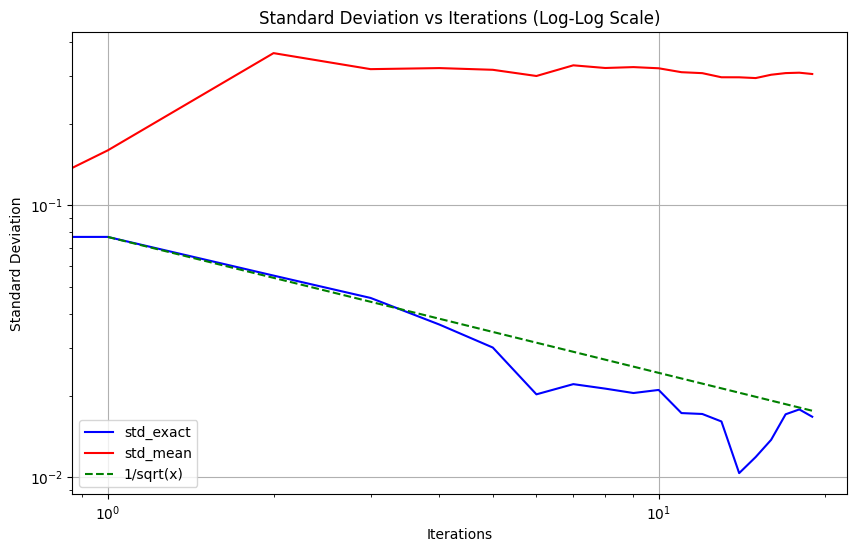

In [13]:
import matplotlib.pyplot as plt
# Plot the results
# Plot the results
iterations = np.arange(offset, len(energy_trajectory))

plt.figure(figsize=(10, 6))

# Plot the std_exact_series in logarithmic scale
plt.loglog(iterations, std_exact_series, label='std_exact', color='b')

# Plot the std_mean_series in logarithmic scale
plt.loglog(iterations, std_mean_series, label='std_mean', color='r')

# Plot 1/sqrt(x)
plt.loglog(iterations, std_exact_series[1]/np.sqrt(iterations), label='1/sqrt(x)', linestyle='--', color='g')

plt.xlabel('Iterations')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation vs Iterations (Log-Log Scale)')
plt.legend()
plt.grid(True)
plt.show()
    

/tmp/ipykernel_12500/741349635.py:15: RuntimeWarning: divide by zero encountered in divide
  plt.loglog(iterations, std_exact_series[1]/np.sqrt(iterations), label='1/sqrt(x)', linestyle='--', color='g')


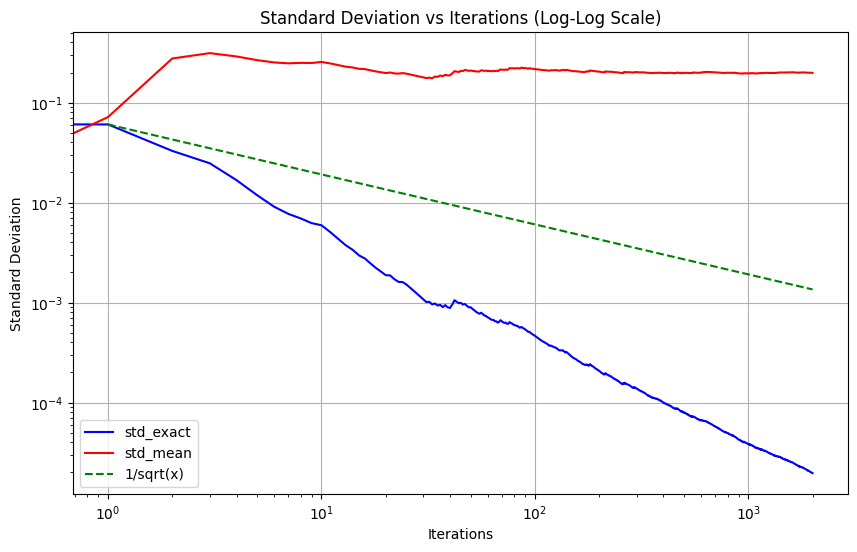

In [456]:
import matplotlib.pyplot as plt
# Plot the results
# Plot the results
iterations = np.arange(offset, len(energy_trajectory))

plt.figure(figsize=(10, 6))

# Plot the std_exact_series in logarithmic scale
plt.loglog(iterations, std_exact_series, label='std_exact', color='b')

# Plot the std_mean_series in logarithmic scale
plt.loglog(iterations, std_mean_series, label='std_mean', color='r')

# Plot 1/sqrt(x)
plt.loglog(iterations, std_exact_series[1]/np.sqrt(iterations), label='1/sqrt(x)', linestyle='--', color='g')

plt.xlabel('Iterations')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation vs Iterations (Log-Log Scale)')
plt.legend()
plt.grid(True)
plt.show()


In [471]:
def downsample_and_average(energy_trajectory, factor=4):
    """
    Downsample the energy trajectory by averaging every 'factor' consecutive values.
    
    Args:
    - energy_trajectory: list or array of energy values
    - factor: number of consecutive values to average
    
    Returns:
    - downsampled_trajectory: list of averaged values
    """
    # Ensure the length is divisible by factor
    length = len(energy_trajectory) // factor * factor
    energy_trajectory = energy_trajectory[:length]
    
    # Reshape the trajectory to group every 'factor' values
    reshaped_trajectory = energy_trajectory.reshape(-1, factor)
    
    # Average over each group of 'factor' values
    downsampled_trajectory = np.mean(reshaped_trajectory, axis=1)
    
    return downsampled_trajectory

# Example usage
downsampled_energy_trajectory = downsample_and_average(np.array(energy_trajectory), factor=50)


/tmp/ipykernel_12500/3111856488.py:16: RuntimeWarning: divide by zero encountered in divide
  plt.loglog(iterations, std_exact_series[1]/np.sqrt(iterations), label='1/sqrt(x)', linestyle='--', color='g')


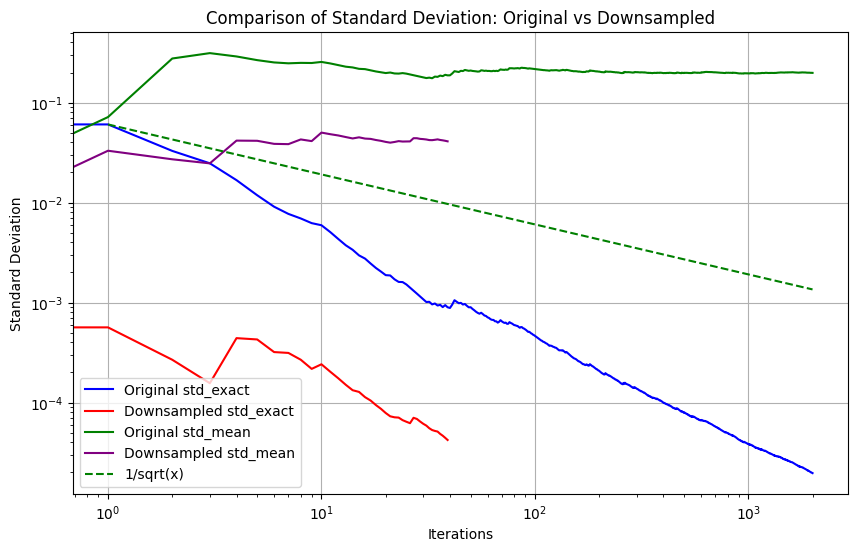

In [472]:
# Compute standard deviation series for the downsampled trajectory
std_exact_series_downsampled, std_mean_series_downsampled = compute_energy_std_series(downsampled_energy_trajectory, exact_energy[0], offset)

# Plotting the comparison
iterations_downsampled = np.arange(offset, len(downsampled_energy_trajectory))

plt.figure(figsize=(10, 6))

# Plot for std_exact
plt.loglog(iterations, std_exact_series, label='Original std_exact', color='b')
plt.loglog(iterations_downsampled, std_exact_series_downsampled, label='Downsampled std_exact', color='r')

# Plot for std_mean
plt.loglog(iterations, std_mean_series, label='Original std_mean', color='g')
plt.loglog(iterations_downsampled, std_mean_series_downsampled, label='Downsampled std_mean', color='purple')
plt.loglog(iterations, std_exact_series[1]/np.sqrt(iterations), label='1/sqrt(x)', linestyle='--', color='g')

plt.xlabel('Iterations')
plt.ylabel('Standard Deviation')
plt.title('Comparison of Standard Deviation: Original vs Downsampled')
plt.legend()
plt.grid(True)
plt.show()


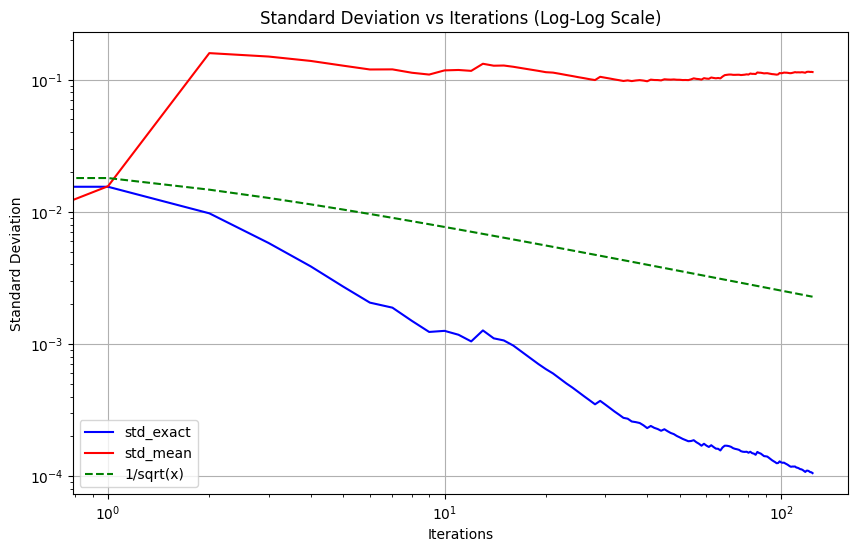

In [400]:
import matplotlib.pyplot as plt
# Plot the results
# Plot the results
iterations = np.arange(offset, len(downsampled_energy_trajectory))

plt.figure(figsize=(10, 6))

# Plot the std_exact_series in logarithmic scale
plt.loglog(iterations, std_exact_series, label='std_exact', color='b')

# Plot the std_mean_series in logarithmic scale
plt.loglog(iterations, std_mean_series, label='std_mean', color='r')

# Plot 1/sqrt(x)
plt.loglog(iterations, std_exact_series[0]/np.sqrt(iterations-offset+1), label='1/sqrt(x)', linestyle='--', color='g')

plt.xlabel('Iterations')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation vs Iterations (Log-Log Scale)')
plt.legend()
plt.grid(True)
plt.show()


In [367]:
res=np.array(energy_trajectory)-exact_energy[0]
np.std(res**2), np.std(energy_trajectory)


(0.01197212616954562, 0.09723864596246669)

In [295]:
np.average(np.array(energy_trajectory))/32, exact_energy[0]

((1.789740333225217-9.068699603131865e-07j),
 <tf.Tensor: shape=(), dtype=complex128, numpy=(1.775517212541465-4.256340559952859e-17j)>)

## Test for checking the stochastic overlap converges with std going to zero as 1/sqrt(N) to the true overlap

In [35]:
from compgraph.useful import copy_to_non_trainable
import importlib
import compgraph.gnn_src_code
import compgraph.useful

importlib.reload(compgraph.gnn_src_code)
importlib.reload(compgraph.useful)
from compgraph.gnn_src_code import GNN_double_output

def copy_and_perturb_weights(sampler_var, sampler_te, perturbation_scale=1e-4):
    """
    Copy the parameters from sampler_var.model to sampler_te.model and perturb the weights
    to make sure they are different.
    
    Args:
        sampler_var: The original sampler whose model weights are copied.
        sampler_te: The target sampler to which the weights are copied and perturbed.
        perturbation_scale: The standard deviation of the normal noise added as a perturbation.

    Returns:
        sampler_te: The sampler with the perturbed weights.
    """
    # # Copy the weights
    # for var_param, te_param in zip(sampler_var.model.trainable_variables, sampler_te.model.trainable_variables):
    #     te_param.assign(var_param)

    # Apply a small perturbation to sampler_te's weights to ensure the models are different
    for param in sampler_var.model.trainable_variables[:1]:
        print('before var param',param)
        
    for param in sampler_te.model.variables:
        perturbation = tf.random.normal(param.shape, mean=0.0, stddev=perturbation_scale, dtype=param.dtype)  # Match dtype
        # print("before pert",param)
        param.assign_add(perturbation)
        # print('after',param)
    for param in sampler_var.model.trainable_variables[:1]:
        print('after',param)
                
    return sampler_te



In [22]:
from compgraph.useful import compare_sonnet_modules

# print("Are the models equal after perturbation?", are_identical)
model_var=GNN_double_output(64,32)
model_te=GNN_double_output(64,32)
model_var(graph_tuples_fix[1])
model_te(graph_tuples_fix[0])

copy_to_non_trainable(model_var, model_te)
model_te(graph_tuples_fix[0])

sampler_var = MCMCSampler(model_var, graph_tuples_fix[0])

sampler_te = MCMCSampler(model_te, graph_tuples_fix[0], 0.05, graph, subl)
are_identical = compare_sonnet_modules(sampler_var.model, sampler_te.model)
print("Are the models equal before perturbation?", are_identical)
sampler_te=copy_and_perturb_weights(sampler_var, sampler_te, 0.005)
are_identical = compare_sonnet_modules(sampler_var.model, sampler_te.model)
print("Are the models equal after perturbation?", are_identical)


The two modules have the same number of layers parameters
Are the models equal before perturbation? True
before var param <tf.Variable 'gnn_double_output/encoder/mlp_model_4layers/layer1/b:0' shape=(64,) dtype=float64, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])>
after <tf.Variable 'gnn_double_output/encoder/mlp_model_4layers/layer1/b:0' shape=(64,) dtype=float64, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])>
The two modules have the same number of layers parameters
Comparison failed at index 0, gnn_

### Testing the stochastic overlap can also reproduce exact overlap according to quimb

In [25]:
from compgraph.monte_carlo import stochastic_overlap
from compgraph.useful import state_from_config_amplitudes
lattice=(2,2)
graph, subl=create_graph_from_ham('2dsquare',lattice,'Neel')

full_basis_configs= np.array([[int(x) for x in format(i, f'0{len(graph.nodes)}b')] for i in range(2**(len(graph.nodes)))]) * 2 - 1

full_basis_gt=create_graph_tuples(full_basis_configs, graph,subl)


# Compute probabilities for each sample
wf_var_on_full=[sampler_var.evaluate_model(gt) for gt in full_basis_gt]
amplitudes_var =np.array(wf_var_on_full)
psi_full=state_from_config_amplitudes(full_basis_configs,amplitudes_var)
psi_norm=psi_full.H@psi_full
psi_stoch_norm=tf.norm(tf.stack(wf_var_on_full))**2
freq_var_as_exact_amplitudes=wf_var_on_full * tf.math.conj(wf_var_on_full)/psi_stoch_norm

wf_te_on_full=[sampler_te.time_evoluted_config_amplitude(gt) for gt in full_basis_gt]
amplitudes_te =np.array(wf_te_on_full)
phi_full=state_from_config_amplitudes(full_basis_configs,amplitudes_te)
phi_norm=phi_full.H@phi_full
phi_stoch_norm=tf.norm(tf.stack(wf_te_on_full))**2
freq_te_as_exact_amplitudes=wf_te_on_full* tf.math.conj(wf_te_on_full)/phi_stoch_norm

overlap_exact=stochastic_overlap(sampler_var, sampler_te, wf_te_on_full, full_basis_gt, full_basis_gt, freq_var_as_exact_amplitudes,freq_te_as_exact_amplitudes)
quimb_overlap=phi_full.H@psi_full*psi_full.H@phi_full/ (phi_full.H@phi_full*psi_full.H@psi_full)
print(overlap_exact, quimb_overlap)
print(f"norms: phi {phi_norm},{phi_stoch_norm}, psi norms {psi_norm}{psi_stoch_norm}")




norms: phi(0.9999999999999998+0j), psi:(1+0j)
tf.Tensor((0.9993097183645113+1.872705143084533e-17j), shape=(), dtype=complex128) [[0.99931-1.616651e-16j]]
norms: phi [[1203.208796+0.j]],(1203.2087964249108+0j), psi norms [[1196.555554+0.j]](1196.5555544066594+0j)


### Testing stochastic overlap over markov chain evolution to see if it converges with sqrt of N


In [38]:
# sampler_te=copy_and_perturb_weights(sampler_var, sampler_te)
from simulation.initializer import initialize_graph_tuples
batch_number=4
graph_tuples_v=initialize_graph_tuples(batch_number, graph, subl)

overlap_trajectory = []

# Perform Markov Chain evolution over a number of iterations
for i in range(2000):
    # Get the number of sites from the first graph tuple
    n_sites = len(graph_tuples_v[0].nodes[:, 0])
    
    # Update the graph tuples using Monte Carlo updates for both samplers
    graph_tuples_var, coeff_var_on_var = zip(*[sampler_var.monte_carlo_update(2, graph_tuple, 'var') for graph_tuple in graph_tuples_v])
    graph_tuples_te, coeff_te_on_te = zip(*[sampler_te.monte_carlo_update(2, graph_tuple, 'te') for graph_tuple in graph_tuples_v])
    
    # Create wavefunctions and frequencies for sampler_var
    wave_function_var_on_var, freq_var = create_amplitude_frequencies_from_graph_tuples(graph_tuples_var, coeff_var_on_var)
    unique_tuples_var = generate_graph_tuples_configs(graph_tuples_var[0], sparse_list_to_configs(freq_var.indices[:, 0], n_sites))
    freq_ampl_var = np.array(freq_var.values) / len(graph_tuples_var)
    
    # Create wavefunctions and frequencies for sampler_te
    wave_function_te_on_te, freq_te = create_amplitude_frequencies_from_graph_tuples(graph_tuples_te, coeff_te_on_te)
    unique_tuples_te = generate_graph_tuples_configs(graph_tuples_te[0], sparse_list_to_configs(freq_te.indices[:, 0], n_sites))
    freq_ampl_te = np.array(freq_te.values) / len(graph_tuples_te)
    
    # Compute stochastic overlap
    stoch_overlap = stochastic_overlap(sampler_var, sampler_te, wave_function_te_on_te.values, unique_tuples_var, unique_tuples_te, freq_ampl_var, freq_ampl_te)
    
    # Append the overlap result to the trajectory list
    overlap_trajectory.append(stoch_overlap.numpy())
    
    # Print the current stochastic overlap for monitoring
    print(f"Iteration {i}: Stochastic Overlap = {stoch_overlap.numpy()}, vs exact:{overlap_exact}")

# Now `overlap_trajectory` contains the stochastic overlap values for each iteration.


norms: phi(1+0j), psi:(1+0j)
Iteration 0: Stochastic Overlap = (0.9491481410915391-0.1119585759103086j), vs exact:(0.9481125878339052+1.3877787807814457e-17j)
norms: phi(1+0j), psi:(1+0j)
Iteration 1: Stochastic Overlap = (0.9639079624937764-0.04460968577890107j), vs exact:(0.9481125878339052+1.3877787807814457e-17j)
norms: phi(1+0j), psi:(1+0j)
Iteration 2: Stochastic Overlap = (0.9503247211910357-0.09298660549434147j), vs exact:(0.9481125878339052+1.3877787807814457e-17j)
norms: phi(1+0j), psi:(1+0j)
Iteration 3: Stochastic Overlap = (0.859230169027823-0.243180650056197j), vs exact:(0.9481125878339052+1.3877787807814457e-17j)
norms: phi(1+0j), psi:(1+0j)
Iteration 4: Stochastic Overlap = (0.999180015178426+0.07071326779816071j), vs exact:(0.9481125878339052+1.3877787807814457e-17j)
norms: phi(1+0j), psi:(1+0j)
Iteration 5: Stochastic Overlap = (0.9543789683080957+0.03167596433263779j), vs exact:(0.9481125878339052+1.3877787807814457e-17j)
norms: phi(1+0j), psi:(1+0j)
Iteration 6: Sto

In [67]:
import numpy as np

def compute_statistics_std_series(trajectory, exact_value, offset=50):
    """
    Compute the standard deviation of the trajectory (energy or overlap) with respect to the exact value
    and the mean of the trajectory up to each point (starting after offset).
    
    Args:
    - trajectory: list or array of values (e.g., energy or overlap)
    - exact_value: the exact value to compare against (scalar)
    - offset: the number of initial steps to ignore in the calculation
    - name: name of the quantity (e.g., "energy" or "overlap") for informative printing
    
    Returns:
    - std_exact_series: list of standard deviations of the series compared to the exact value
    - std_mean_series: list of standard deviations of the series compared to the rolling mean
    """
    if len(trajectory) <= offset:
        raise ValueError(f"Not enough data points to compute statistics after offset.")
    
    # Convert to numpy array for easier manipulation
    trajectory = np.array(trajectory)
    
    # Initialize lists to store results
    std_exact_series = []
    std_mean_series = []
    
    # Iterate through the trajectory, starting from the offset point
    for i in range(offset, len(trajectory)):
        # Compute the current segment of the trajectory from offset to the current point
        current_trajectory = trajectory[offset:i+1]
        
        # Compute the standard deviation with respect to the exact value
        current_trajectory -= exact_value
        std_exact = np.mean(abs(current_trajectory)**2) / len(current_trajectory)
        std_exact_series.append(std_exact)
        current_trajectory += exact_value
        
        # Compute the rolling mean of the current trajectory
        mean_estimate = np.mean(current_trajectory)
        
        # Compute the standard deviation with respect to the rolling mean
        current_trajectory -= mean_estimate
        std_mean = np.std(current_trajectory)
        std_mean_series.append(std_mean)
    
    return std_exact_series, std_mean_series


# Example usage for overlap:
std_exact_overlap_series, std_mean_overlap_series = compute_statistics_std_series(
    overlap_trajectory[:200], overlap_exact, 0
)

print("Standard Deviation wrt Exact Overlap:", std_exact_overlap_series)
print("Standard Deviation wrt Rolling Mean (Overlap):", std_mean_overlap_series)


Standard Deviation wrt Exact Overlap: [0.012535795090413733, 0.0036938282540879314, 0.002602968372411306, 0.005653976767892254, 0.003922875066582334, 0.0027531808584780066, 0.0024159669374161094, 0.0020390336377226854, 0.0016254556438130771, 0.001326495931746036, 0.001152719446618409, 0.0010111151562126382, 0.0008761332126670372, 0.0010161200212957752, 0.000972540147587982, 0.0008639399955575185, 0.0007755861233260084, 0.0007532398227345612, 0.0007167654281257656, 0.0007421735812057814, 0.0007753152114278355, 0.0007079563969768443, 0.0006773574717893739, 0.0006241751228059919, 0.0005973706718313046, 0.0005746597181868452, 0.0005342171493578646, 0.0004972879743641404, 0.0004783636082946503, 0.0004997754131698471, 0.00046811480696655044, 0.0004454447019049063, 0.0004206812550375832, 0.0004854590816579118, 0.0004790116354930742, 0.0004556403774309855, 0.00043223084798639803, 0.0004108251059907412, 0.0003928622231601505, 0.0004011089481781727, 0.00039835450213432773, 0.0003816113060813684,

In [81]:

import numpy as np

def compute_statistics_std_series_with_subsampling(trajectory, exact_value, offset=50, max_samples=None):
    """
    Compute the standard deviation of the trajectory (energy or overlap) with respect to the exact value
    and the mean of the trajectory up to each point using random subsampling to avoid autocorrelation effects.
    
    Args:
    - trajectory: list or array of values (e.g., energy or overlap)
    - exact_value: the exact value to compare against (scalar)
    - offset: the number of initial steps to ignore in the calculation
    - max_samples: the maximum number of samples to randomly choose at each step (None for all available)
    
    Returns:
    - std_exact_series: list of standard deviations of the series compared to the exact value
    - std_mean_series: list of standard deviations of the series compared to the rolling mean
    """
    if len(trajectory) <= offset:
        raise ValueError(f"Not enough data points to compute statistics after offset.")
    
    # Convert to numpy array for easier manipulation
    trajectory = np.array(trajectory)
    
    # Initialize lists to store results
    std_exact_series = []
    std_mean_series = []
    
    # Iterate through the trajectory, starting from the offset point
    for i in range(offset, len(trajectory)):
    # for i in range(offset, 10):
    
        # Randomly sample from the trajectory up to this point
        sample_size = min(i - offset + 1, max_samples if max_samples is not None else i - offset + 1)
        random_indices = np.random.choice(range(offset, len(trajectory)), size=sample_size, replace=False)
        # print(random_indices)
        current_trajectory = trajectory[random_indices]
        # print(current_trajectory, trajectory[offset:i+1],trajectory[random_indices[i]])
        # Compute the standard deviation with respect to the exact value
        current_trajectory -= exact_value
        std_exact = np.mean(abs(current_trajectory)**2) / sample_size
        std_exact_series.append(np.sqrt(std_exact))
        current_trajectory += exact_value
        
        # Compute the rolling mean of the current trajectory
        mean_estimate = np.mean(current_trajectory)
        
        # Compute the standard deviation with respect to the rolling mean
        current_trajectory -= mean_estimate
        std_mean = np.std(current_trajectory)
        
        std_mean_series.append(std_mean)
    
    return std_exact_series, std_mean_series


# Example usage for overlap:
std_exact_overlap_series_from_rand, std_mean_overlap_series_from_rand = compute_statistics_std_series_with_subsampling(
    overlap_trajectory, overlap_exact, offset=0
)

print("Standard Deviation wrt Exact Overlap:", std_exact_overlap_series_from_rand)
print("Standard Deviation wrt Rolling Mean (Overlap):", std_mean_overlap_series_from_rand)



Standard Deviation wrt Exact Overlap: [0.11061739779141493, 0.07596531076990308, 0.06931644951865763, 0.049583715472907644, 0.042473952708983694, 0.06146196474567212, 0.03883222075108261, 0.05858551077885513, 0.05273784197265906, 0.03342895295315739, 0.046348886422058, 0.03809045870096228, 0.03568433941402358, 0.04076004381477198, 0.03341591774617243, 0.02952538601825548, 0.030438878734126835, 0.029370612681662776, 0.032476850854642456, 0.027373986403044528, 0.025699592134506545, 0.025676997243722202, 0.024347306674207425, 0.026353812854022083, 0.027225455001127927, 0.024701684967577107, 0.023678490245610796, 0.02284043193854094, 0.024817567481110244, 0.02606664947035869, 0.022517634430879386, 0.020873679226660547, 0.024550464260967818, 0.025098049386684123, 0.023782991949192936, 0.023707587831795853, 0.024174859166244195, 0.021255120792817304, 0.0192781351141362, 0.01765742427516981, 0.021988590719307578, 0.01980641437643007, 0.020993025779551474, 0.02294912560610079, 0.02221165245497

/tmp/ipykernel_20073/1605904573.py:15: RuntimeWarning: divide by zero encountered in divide
  plt.loglog(iterations, std_exact_overlap_series_from_rand[1]/np.sqrt(iterations), label='1/sqrt(x)', linestyle='--', color='g')


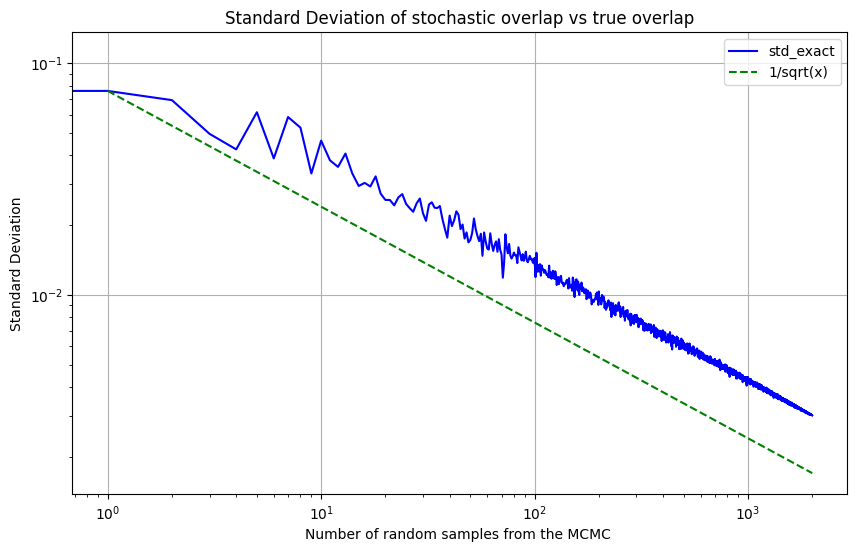

In [82]:
import matplotlib.pyplot as plt
# Plot the results
# Plot the results
iterations = np.arange(0, len(overlap_trajectory))

plt.figure(figsize=(10, 6))

# Plot the std_exact_series in logarithmic scale
plt.loglog(iterations, std_exact_overlap_series_from_rand, label='std_exact', color='b')

# Plot the std_mean_series instd_mean_overlap_serieslogarithmic scale
# plt.loglog(iterations, std_mean_series, label='std_mean', color='r')

# Plot 1/sqrt(x)
plt.loglog(iterations, std_exact_overlap_series_from_rand[1]/np.sqrt(iterations), label='1/sqrt(x)', linestyle='--', color='g')

plt.xlabel('Number of random samples from the MCMC ')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation of stochastic overlap vs true overlap')
plt.legend()
plt.grid(True)
plt.show()


In [26]:
np.mean(np.array(overlap_trajectory)**2)

(0.9999904948300256+5.923994272547394e-13j)

## Going to FD

In [36]:
import numpy as np
import tensorflow as tf
from compgraph.monte_carlo import stochastic_overlap
from compgraph.useful import state_from_config_amplitudes, create_graph_tuples

def exact_coeff_on_fhs_from_sampler(sampler, sampler_type,graph, subl):
    """
    General-purpose function to compute the coefficients on the full Hilbert space
    for either the variational (var) or time-evolved (te) case.

    Args:
    - sampler: MCMCSampler object (model_var or model_te)
    - sampler_type: string, either 'var' or 'te' to specify the case
    - graph: networkx graph representing the lattice
    - sublattice: sublattice encoding of the system
    - full_basis_configs: array of all configurations (full Hilbert space)
    - beta: float (optional), required if sampler_type is 'te' for time-evolution
    
    Returns:
    - coeffs: sparse tensor of coefficients for the full basis
    - norm: the norm of the full state
    - freq_as_exact_amplitudes: frequencies as exact amplitudes for overlap computation
    """
    full_basis_configs = np.array([[int(x) for x in format(i, f'0{len(graph.nodes)}b')] for i in range(2**(len(graph.nodes)))]) * 2 - 1

    # Generate graph tuples from full basis configurations
    full_basis_gt = create_graph_tuples(full_basis_configs, graph, subl)

    if sampler_type == 'var':
        # Compute coefficients for the variational case
        wf_on_full = [sampler.evaluate_model(gt) for gt in full_basis_gt]
    elif sampler_type == 'te':
        
        # Compute coefficients for the time-evolved case
        wf_on_full = [sampler.time_evoluted_config_amplitude(gt) for gt in full_basis_gt]
    else:
        raise ValueError("Invalid sampler type. Use 'var' for variational or 'te' for time-evolved.")
    


    # Compute the stochastic norm (using the wavefunction values directly)
    psi_stoch_norm = tf.norm(tf.stack(wf_on_full))**2

    # Compute the frequencies as exact amplitudes for the overlap calculation
    freq_as_exact_amplitudes = wf_on_full * tf.math.conj(wf_on_full) / psi_stoch_norm

    return wf_on_full, psi_stoch_norm, freq_as_exact_amplitudes




In [37]:
importlib.reload(compgraph.monte_carlo)
from compgraph.monte_carlo import stochastic_overlap, MCMCSampler, copy_and_perturb_weights
from gnn_src_code import GNN_double_output
from simulation.initializer import initialize_graph_tuples, create_graph_from_ham
from compgraph.useful import create_graph_tuples,copy_to_non_trainable
lattice=(2,2)
graph, subl=create_graph_from_ham('2dsquare',lattice,'Neel')
beta=0.12
graph_tuples_var=initialize_graph_tuples(4,graph,subl)
graph_tuples_te=initialize_graph_tuples(4,graph,subl)
full_basis_configs = np.array([[int(x) for x in format(i, f'0{len(graph.nodes)}b')] for i in range(2**(len(graph.nodes)))]) * 2 - 1

graph_tuples_full_hilbert=create_graph_tuples(full_basis_configs, graph,subl)
model_var=GNN_double_output(32,16)
model_te=GNN_double_output(32,16)
sampler_var=MCMCSampler(model_var,graph_tuples_var[0])
sampler_te=MCMCSampler(model_te,graph_tuples_var[0],beta,graph,subl)
# model_var(graph_tuples_var[0])
## Here we first copy the weights of the model of sampler var to the model of  sampler te with a perturbation 
# that is enough to produce a different enough state, this is done to better check the gradient of the stochastic overlap function without being fooled by rounding errors
updated_sampler_te=copy_and_perturb_weights(sampler_var, sampler_te,0.05)
copy_to_non_trainable(updated_sampler_te.model, sampler_te.model)

coeff_te_on_full, norm_te, freq_te_on_full=exact_coeff_on_fhs_from_sampler(sampler_te, 'te',graph,subl)
with tf.GradientTape() as tape:
    tape.watch(sampler_var.model.trainable_variables)
    coeff_var_on_full, norm_var, freq_var_on_full=exact_coeff_on_fhs_from_sampler(sampler_var, 'var',graph,subl)

    full_overlap=stochastic_overlap(sampler_var,sampler_te,coeff_te_on_full,graph_tuples_full_hilbert,graph_tuples_full_hilbert, freq_var_on_full, freq_te_on_full)    
    log_overlap=-tf.math.log(tf.norm(full_overlap)) 
exact_gradients = tape.gradient(log_overlap, sampler_var.model.trainable_variables)
exact_gradients[0], log_overlap

norms: phi(1.0000000000000002+0j), psi:(1+0j)


(<tf.Tensor: shape=(32,), dtype=float64, numpy=
 array([-0.1606225 ,  0.09741239,  0.02896228,  0.06054911,  0.07851725,
        -0.01517283,  0.01381629,  0.02900404, -0.15699079, -0.13198401,
        -0.00133999,  0.1350392 , -0.14047776, -0.33053055,  0.13805552,
        -0.24905396,  0.04144846,  0.17662376,  0.08942685,  0.04312955,
         0.1065521 ,  0.01153057, -0.14281999,  0.09246224, -0.00629567,
        -0.05193287, -0.03133523,  0.18087054, -0.10109154, -0.06129784,
         0.09268916, -0.04037896])>,
 <tf.Tensor: shape=(), dtype=complex128, numpy=(0.10699037092653291-0j)>)

In [38]:
import compgraph.tensor_wave_functions


importlib.reload(compgraph.tensor_wave_functions)
from compgraph.tensor_wave_functions import montecarlo_logloss_overlap_time_evoluted, time_evoluted_wave_function_on_batch,variational_wave_function_on_batch

with tf.GradientTape() as tape:
    te_wave_on_te= time_evoluted_wave_function_on_batch(sampler_te.model,beta,graph_tuples_full_hilbert,G)
    tape.watch(model_var.trainable_variables)
    #print("output: \n", output)
        
    loss = 2*montecarlo_logloss_overlap_time_evoluted(te_wave_on_te, graph_tuples_full_hilbert, sampler_var.model, sampler_te.model, graph_tuples_full_hilbert, beta, G)
    
#print("Is it lossing: \n", loss, type(loss))
gradients = tape.gradient(loss, sampler_var.model.trainable_variables) 

gradients[0], loss

(<tf.Tensor: shape=(32,), dtype=float64, numpy=
 array([-0.1606225 ,  0.09741239,  0.02896228,  0.06054911,  0.07851725,
        -0.01517283,  0.01381629,  0.02900404, -0.15699079, -0.13198401,
        -0.00133999,  0.1350392 , -0.14047776, -0.33053055,  0.13805552,
        -0.24905396,  0.04144846,  0.17662376,  0.08942685,  0.04312955,
         0.1065521 ,  0.01153057, -0.14281999,  0.09246224, -0.00629567,
        -0.05193287, -0.03133523,  0.18087054, -0.10109154, -0.06129784,
         0.09268916, -0.04037896])>,
 <tf.Tensor: shape=(), dtype=complex128, numpy=(0.10699037092653226+0j)>)

In [39]:
import numpy as np
import tensorflow as tf
from simulation.initializer import initialize_graph_tuples

# Initialize samplers and batch number
batch_number = 32
graph_tuples_v = initialize_graph_tuples(batch_number, graph, subl)

stoch_gradient_trajectory = []
# mse_trajectory = []

# Perform Markov Chain evolution and gradient calculation over a number of iterations
for i in range(200):
    n_sites = len(graph_tuples_v[0].nodes[:, 0])
    
    # Update the graph tuples using Monte Carlo updates for both samplers
    graph_tuples_var, coeff_var_on_var = zip(*[sampler_var.monte_carlo_update(2, graph_tuple, 'var') for graph_tuple in graph_tuples_v])
    graph_tuples_te, coeff_te_on_te = zip(*[sampler_te.monte_carlo_update(2, graph_tuple, 'te') for graph_tuple in graph_tuples_v])
    
    # Create wavefunctions and frequencies for sampler_var
    wave_function_var_on_var, freq_var = create_amplitude_frequencies_from_graph_tuples(graph_tuples_var, coeff_var_on_var)
    unique_tuples_var = generate_graph_tuples_configs(graph_tuples_var[0], sparse_list_to_configs(freq_var.indices[:, 0], n_sites))
    freq_ampl_var = np.array(freq_var.values) / len(graph_tuples_var)
    
    # Create wavefunctions and frequencies for sampler_te
    wave_function_te_on_te, freq_te = create_amplitude_frequencies_from_graph_tuples(graph_tuples_te, coeff_te_on_te)
    unique_tuples_te = generate_graph_tuples_configs(graph_tuples_te[0], sparse_list_to_configs(freq_te.indices[:, 0], n_sites))
    freq_ampl_te = np.array(freq_te.values) / len(graph_tuples_te)
    print('frequencies',freq_te.values)
    # Compute stochastic overlap and gradients
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(sampler_var.model.trainable_variables)
        wave_function_var_on_var, freq_var = create_amplitude_frequencies_from_graph_tuples(graph_tuples_var, coeff_var_on_var)
    
        stoch_overlap = stochastic_overlap(sampler_var, sampler_te, wave_function_te_on_te.values, unique_tuples_var, unique_tuples_te, freq_ampl_var, freq_ampl_te)
        log_overlap=-tf.math.log(tf.norm(stoch_overlap)) 

    # Compute stochastic gradients
    stoch_gradients = tape.gradient(log_overlap, sampler_var.model.trainable_variables)
    print(stoch_gradients[0], log_overlap)
    stoch_gradient_trajectory.append(stoch_gradients)



frequencies tf.Tensor([7 1 1 1 5 2 3 1 3 1 1 1 2 3], shape=(14,), dtype=int32)
norms: phi(1+0j), psi:(1+0j)
tf.Tensor(
[ 0.47398612 -0.13726054  0.0998565  -0.09366808 -0.53099454  0.01535146
 -0.05913655 -0.0752279   0.44103143  0.20769033 -0.01756425 -0.32776295
  0.37610929  1.10321715 -0.3679485   0.73290608 -0.07478442 -0.46589244
 -0.3081528  -0.04083774 -0.20684306 -0.01839124  0.73512514  0.03454662
 -0.00282974  0.10313879  0.26951471 -0.44072524  0.26897823  0.07227316
 -0.25829947 -0.1304094 ], shape=(32,), dtype=float64) tf.Tensor((-0.17695234278536517-0j), shape=(), dtype=complex128)
frequencies tf.Tensor([11  2  1  2  3  2  1  2  3  3  2], shape=(11,), dtype=int32)
norms: phi(1+0j), psi:(1+0j)
tf.Tensor(
[-0.3017231   0.12296501 -0.01899956  0.07492879  0.14158736 -0.03438413
  0.015351    0.08981783 -0.20393297 -0.16273785  0.01917307  0.29322668
 -0.2198996  -0.71917563  0.29902934 -0.39737884  0.12407924  0.2953018
  0.2247636  -0.0045077   0.1388192  -0.01673626 -0.30

In [118]:
import numpy as np
import numpy as np
import tensorflow as tf

def measure_distance_stochastic_exact_grad(trajectory, exact_gradients, offset=50, max_samples=None):
    """
    Compute the MSE of the trajectory of gradients with respect to the exact gradients,
    using random subsampling to avoid autocorrelation effects.
    
    Args:
    - trajectory: list of gradient arrays (stochastic gradient trajectory)
    - exact_gradients: list of exact gradient arrays
    - offset: the number of initial steps to ignore in the calculation
    - max_samples: the maximum number of samples to randomly choose at each step (None for all available)
    
    Returns:
    - mse_mean_series: list of MSE values with respect to the rolling mean of the gradients
    - cosine_similarity_series: list of cosine similarities between the mean and exact gradients
    """
    if len(trajectory) <= offset:
        raise ValueError(f"Not enough data points to compute statistics after offset.")
    
    # Initialize lists to store results
    mse_mean_series = []
    cosine_similarity_series = []
    
    # Iterate through the trajectory, starting from the offset point
    for i in range(offset, len(trajectory)):
    
        # Randomly sample from the trajectory up to this point
        sample_size = min(i - offset + 1, max_samples if max_samples is not None else i - offset + 1)
        random_indices = np.random.choice(range(offset, len(trajectory)), size=sample_size, replace=False)
        
        # Compute the rolling mean of the subsampled gradients without stacking to save memory
        mean_grads = []
        for var_index in range(len(exact_gradients)):
            # Initialize the sum of gradients for the current variable
            grad_sum = tf.zeros_like(exact_gradients[var_index])
            
            # Sum gradients over the random sample
            for j in random_indices:
                grad_sum += trajectory[j][var_index]
            
            # Compute the mean gradient for this variable
            mean_grad = grad_sum / sample_size
            mean_grads.append(mean_grad)

        # Compute the MSE with respect to the exact gradients for each variable
        mse_exact = np.mean([
            tf.reduce_mean(tf.square(mean_grad - exact_gradients[var_index])).numpy()
            for var_index, mean_grad in enumerate(mean_grads)
        ])
        
        # Compute cosine similarity for each variable's gradients
        total_cosine_similarity = 0
        for var_index, mean_grad in enumerate(mean_grads):
            # Flatten gradients to 1D
            exact_grad = tf.reshape(exact_gradients[var_index], [-1])
            mean_grad = tf.reshape(mean_grad, [-1])
            
            # Compute cosine similarity
            dot_product = tf.reduce_sum(tf.multiply(mean_grad, exact_grad))
            norm_mean_grad = tf.norm(mean_grad)
            norm_exact_grad = tf.norm(exact_grad)
            cosine_similarity = dot_product / (norm_mean_grad * norm_exact_grad)
            
            total_cosine_similarity += cosine_similarity.numpy()
        
        # Average cosine similarity across all variables
        avg_cosine_similarity = total_cosine_similarity / len(exact_gradients)
        cosine_similarity_series.append(avg_cosine_similarity)
    
        # Save the MSE value for this subsampling step
        mse_mean_series.append(mse_exact)
    
    return mse_mean_series, cosine_similarity_series




In [51]:
mse_mean_series,cosine_simil_series = measure_distance_stochastic_exact_grad(
    stoch_gradient_trajectory, exact_gradients, offset=0
)


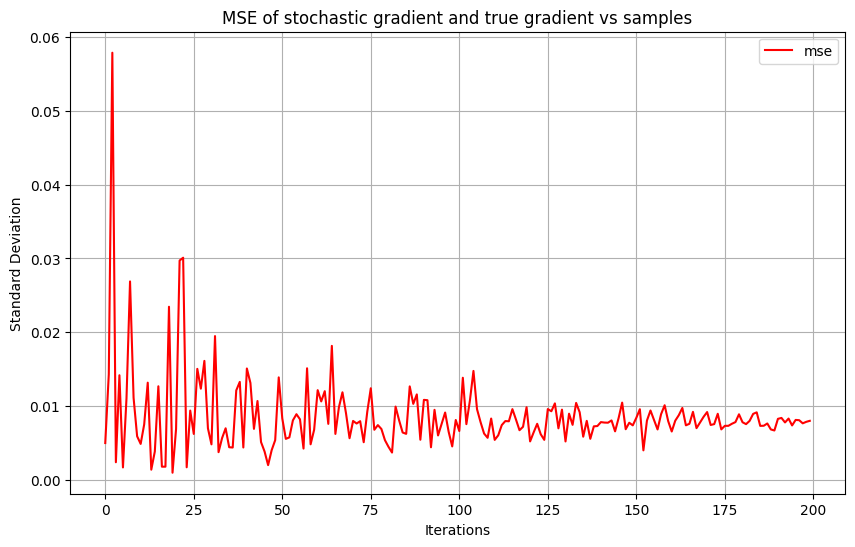

In [59]:
import matplotlib.pyplot as plt
# Plot the results
# Plot the results
iterations = np.arange(offset, len(stoch_gradient_trajectory))

plt.figure(figsize=(10, 6))

# Plot the std_exact_series in logarithmic scale
# plt.loglog(iterations, cosine_simil_series, label='cosine sim', color='b')

# Plot the std_mean_series in logarithmic scale
plt.plot(iterations, mse_mean_series, label='mse', color='r')

# Plot 1/sqrt(x)
# plt.loglog(iterations, mse_mean_series[0]/np.sqrt(iterations-offset+1), label='1/sqrt(x)', linestyle='--', color='g')

plt.xlabel('Iterations')
plt.ylabel('Standard Deviation')
plt.title('MSE of stochastic gradient and true gradient vs samples')
plt.legend()
plt.grid(True)
plt.show()

In [102]:
def stochastic_gradients(sampler_var,sampler_te, unique_tuples_var,freq_ampl_var):
    with tf.GradientTape() as tape:
        tape.watch(sampler_var.model.trainable_variables)
        psi_terms= tf.stack([sampler_var.evaluate_model(gt) for gt in unique_tuples_var])
        phi_terms= tf.stack([sampler_te.time_evoluted_config_amplitude(gt) for gt in unique_tuples_var])
        # print(psi_terms)

        log_psi=tf.math.log(tf.math.conj(psi_terms))
        ratio_phi_psi = tf.stop_gradient(phi_terms / psi_terms)
        # print(ratio_phi_psi, phi_terms)
        # log_psi_gradients=tape.gradient(log_psi, sampler_var.model.trainable_variables)
        stoch_estimation=freq_ampl_var*log_psi -ratio_phi_psi*log_psi*freq_ampl_var/tf.reduce_sum(ratio_phi_psi*freq_ampl_var)
        stoch_gradients=tape.gradient(stoch_estimation, sampler_var.model.trainable_variables)
        # print(stoch_gradients[0])
    return stoch_gradients    

In [96]:
stoch_gradients[0]

<tf.Tensor: shape=(32,), dtype=float64, numpy=
array([-0.31821297,  0.18957855,  0.04921581,  0.11979523,  0.11962097,
       -0.0473038 ,  0.0188228 ,  0.09445874, -0.25659931, -0.23109904,
        0.0040318 ,  0.32575306, -0.23733398, -0.72689528,  0.29458498,
       -0.43749608,  0.12272015,  0.34792355,  0.22275363,  0.0302719 ,
        0.20328168, -0.0167708 , -0.26436148,  0.06723594,  0.01672397,
       -0.11208363, -0.08979871,  0.3104713 , -0.14452667, -0.05635911,
        0.1472508 ,  0.03251953])>

In [113]:
len(graph_tuples_v)

32

In [105]:

import compgraph.useful

importlib.reload(compgraph.monte_carlo)
importlib.reload(compgraph.useful)
from compgraph.monte_carlo import stochastic_overlap, MCMCSampler, copy_and_perturb_weights
from gnn_src_code import GNN_double_output
from simulation.initializer import initialize_graph_tuples, create_graph_from_ham
from compgraph.useful import create_graph_tuples,copy_to_non_trainable
# Perform Markov Chain evolution and gradient calculation over a number of iterations
for i in range(200):
    n_sites = len(graph_tuples_v[0].nodes[:, 0])
    
    # Update the graph tuples using Monte Carlo updates for both samplers
    graph_tuples_var, coeff_var_on_var = zip(*[sampler_var.monte_carlo_update(2, graph_tuple, 'var') for graph_tuple in graph_tuples_v])
    # graph_tuples_te, coeff_te_on_te = zip(*[sampler_te.monte_carlo_update(2, graph_tuple, 'te') for graph_tuple in graph_tuples_v])
    
    # Create wavefunctions and frequencies for sampler_var
    wave_function_var_on_var, freq_var = create_amplitude_frequencies_from_graph_tuples(graph_tuples_var, coeff_var_on_var)
    unique_tuples_var = generate_graph_tuples_configs(graph_tuples_var[0], sparse_list_to_configs(freq_var.indices[:, 0], n_sites))
    freq_ampl_var = np.array(freq_var.values) / len(graph_tuples_var)
    print(freq_ampl_var, i)

    stoch_gradients=stochastic_gradients(sampler_var,sampler_te,unique_tuples_var,freq_ampl_var)
    stoch_gradient_trajectory.append(stoch_gradients)




[0.28125 0.03125 0.03125 0.03125 0.09375 0.0625  0.03125 0.0625  0.09375
 0.03125 0.03125 0.09375 0.125  ] 0
[0.28125 0.03125 0.15625 0.0625  0.03125 0.03125 0.09375 0.09375 0.03125
 0.03125 0.03125 0.09375 0.03125] 1
[0.28125 0.09375 0.0625  0.0625  0.03125 0.09375 0.03125 0.0625  0.03125
 0.0625  0.09375 0.09375] 2
[0.1875  0.09375 0.03125 0.09375 0.125   0.0625  0.03125 0.09375 0.03125
 0.09375 0.03125 0.09375 0.03125] 3
[0.21875 0.03125 0.0625  0.09375 0.1875  0.03125 0.03125 0.0625  0.0625
 0.0625  0.0625  0.09375] 4
[0.25    0.09375 0.0625  0.0625  0.09375 0.03125 0.03125 0.03125 0.0625
 0.09375 0.125   0.0625 ] 5
[0.28125 0.03125 0.09375 0.03125 0.0625  0.0625  0.03125 0.03125 0.1875
 0.0625  0.09375 0.03125] 6
[0.21875 0.0625  0.125   0.03125 0.09375 0.09375 0.03125 0.0625  0.09375
 0.03125 0.09375 0.0625 ] 7
[0.34375 0.03125 0.03125 0.0625  0.09375 0.09375 0.0625  0.03125 0.09375
 0.03125 0.0625  0.0625 ] 8
[0.3125  0.0625  0.03125 0.0625  0.03125 0.125   0.125   0.03125 0.031

In [133]:
stoch_gradients[260]

IndexError: tuple index out of range

In [170]:
rand=np.random.randint(1,199,1)
stoch_gradient_trajectory[260+rand[0]][0], exact_gradients[0]

(<tf.Tensor: shape=(32,), dtype=float64, numpy=
 array([-0.06399191,  0.03297862,  0.00075873,  0.01784668,  0.06741603,
        -0.00053848,  0.00812436,  0.00352034, -0.07188029, -0.04587989,
         0.00266362,  0.03852661, -0.05744649, -0.1284584 ,  0.05330529,
        -0.10072652,  0.00852693,  0.06597062,  0.03628639,  0.01562826,
         0.02900666,  0.00865003, -0.085693  ,  0.02695912, -0.00713002,
        -0.01607725, -0.0256529 ,  0.0678994 , -0.04796225, -0.02697926,
         0.04426049, -0.01106071])>,
 <tf.Tensor: shape=(32,), dtype=float64, numpy=
 array([-0.1606225 ,  0.09741239,  0.02896228,  0.06054911,  0.07851725,
        -0.01517283,  0.01381629,  0.02900404, -0.15699079, -0.13198401,
        -0.00133999,  0.1350392 , -0.14047776, -0.33053055,  0.13805552,
        -0.24905396,  0.04144846,  0.17662376,  0.08942685,  0.04312955,
         0.1065521 ,  0.01153057, -0.14281999,  0.09246224, -0.00629567,
        -0.05193287, -0.03133523,  0.18087054, -0.10109154, -0.0

In [119]:
len(stoch_gradient_trajectory)
mse_mean_series,cosine_simil_series = measure_distance_stochastic_exact_grad(
    stoch_gradient_trajectory[260:], exact_gradients, offset=0
)


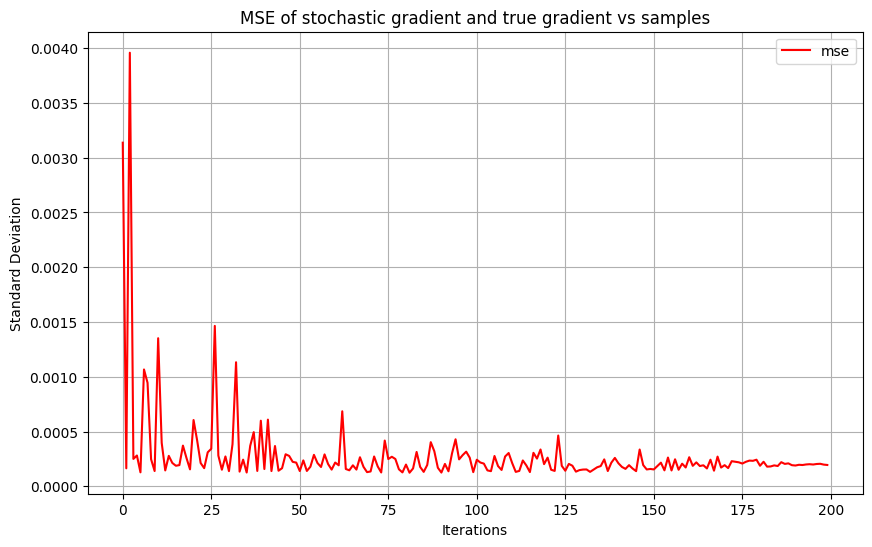

In [124]:
import matplotlib.pyplot as plt
# Plot the results
# Plot the results
iterations = np.arange(offset, 200)

plt.figure(figsize=(10, 6))

# Plot the std_exact_series in logarithmic scale
# plt.plot(iterations, cosine_simil_series, label='cosine sim', color='b')

# Plot the std_mean_series in logarithmic scale
plt.plot(iterations, mse_mean_series, label='mse', color='r')

# Plot 1/sqrt(x)
# plt.loglog(iterations, mse_mean_series[0]/np.sqrt(iterations-offset+1), label='1/sqrt(x)', linestyle='--', color='g')

plt.xlabel('Iterations')
plt.ylabel('Standard Deviation')
plt.title('MSE of stochastic gradient and true gradient vs samples')
plt.legend()
plt.grid(True)

In [273]:
from compgraph.tensor_wave_functions import calculate_sparse_overlap, create_sparse_tensor_from_graph_tuples_amplitudes
psi_var=create_sparse_tensor_from_graph_tuples_amplitudes(full_basis_gt,wave_function_var_on_full)
psi_var, calculate_sparse_overlap(psi_var, psi_var)

(SparseTensor(indices=tf.Tensor(
 [[ 0  0]
  [ 1  0]
  [ 2  0]
  [ 3  0]
  [ 4  0]
  [ 5  0]
  [ 6  0]
  [ 7  0]
  [ 8  0]
  [ 9  0]
  [10  0]
  [11  0]
  [12  0]
  [13  0]
  [14  0]
  [15  0]], shape=(16, 2), dtype=int64), values=tf.Tensor(
 [0.97586253-1.51717103j 2.69587644-4.19811548j 2.2303117 -3.47127937j
  2.29966508-3.58124395j 2.69587644-4.19811548j 2.87919675-4.48368257j
  3.98470535-6.20563307j 2.26392911-3.52566192j 2.2303117 -3.47127937j
  3.98470535-6.20563307j 1.95707126-3.04591781j 2.21428176-3.4483225j
  2.29966508-3.58124395j 2.26392911-3.52566192j 2.21428176-3.4483225j
  0.42786354-0.66627313j], shape=(16,), dtype=complex128), dense_shape=tf.Tensor([16  1], shape=(2,), dtype=int64)),
 <tf.Tensor: shape=(), dtype=complex128, numpy=(342.91634751842605+0j)>)

In [272]:
random=np.random.randint(15)
sampler_var.model(full_basis_gt[random])

<tf.Tensor: shape=(1, 2), dtype=float64, numpy=array([[ 4.09804487, -0.99997139]])>

In [94]:
graph.nodes, graph.edges

(NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8)),
 EdgeView([(0, 3), (0, 1), (0, 6), (0, 2), (1, 4), (1, 2), (1, 7), (2, 5), (2, 8), (3, 6), (3, 4), (3, 5), (4, 7), (4, 5), (5, 8), (6, 7), (6, 8), (7, 8)]))

In [83]:
psi_full.H@Hamiltonian@psi_full/(psi_full.H@psi_full),psi_full.H@psi_full

([[-0.468897+5.551115e-17j]], [[512.+0.j]])

In [74]:
qu.groundstate(Hamiltonian), qu.groundenergy(Hamiltonian)

([[ 0.000000e+00]
  [ 0.000000e+00]
  [ 0.000000e+00]
  [-2.886751e-01]
  [ 0.000000e+00]
  [-2.886751e-01]
  [ 5.773503e-01]
  [ 0.000000e+00]
  [ 0.000000e+00]
  [ 5.773503e-01]
  [-2.886751e-01]
  [ 3.033340e-33]
  [-2.886751e-01]
  [ 3.054405e-33]
  [-7.032106e-21]
  [ 0.000000e+00]],
 -3.999999999999999)

In [75]:
psi_full.H@psi_full

[[31.536084+0.j]]

In [7]:
import tensorflow as tf

random=np.random.randint(16)

new_conf=update_graph_tuple_config(full_basis_gt[0], full_basis_configs[random])
new_confv2=update_graph_tuple_config_old(full_basis_gt[0], full_basis_configs[random], subl)

new_conf.nodes,new_confv2.nodes, full_basis_gt[0].nodes, full_basis_configs[4]

NameError: name 'update_graph_tuple_config' is not defined

# Test for checking Finite difference on full hilbert space

In [74]:
import tensorflow as tf
import unittest
import numpy as np
import quimb as qu
import networkx as nx
import tensorflow as tf
from compgraph.cg_repr import *
from compgraph.tensor_wave_functions import evaluate_model, variational_wave_function_on_batch, sparse_tensor_exp_energy, create_sparsetensor_from_configs_amplitudes, time_evoluted_wave_function_on_batch, montecarlo_logloss_overlap_time_evoluted, calculate_sparse_overlap, quimb_vec_to_sparse
from simulation.initializer import create_graph_from_ham
import itertools
from compgraph.monte_carlo import MCMCSampler
import importlib
import compgraph.gnn_src_code
importlib.reload(compgraph.gnn_src_code)
importlib.reload(compgraph.useful)

from compgraph.gnn_src_code import GNN_double_output, PoolingLayer_double
from compgraph.useful import create_graph_tuples, node_to_index, neel_state, state_from_config_amplitudes, config_to_state

"""
Computes finite difference gradients and compares them with TensorFlow's automatic differentiation.
"""
n, m = 2,2
num_sites = n * m
lattice_size = (n, m)
G = nx.grid_2d_graph(*lattice_size, periodic=True)
mapping = {node: idx for idx, node in enumerate(G.nodes())}
G = nx.relabel_nodes(G, mapping)
sublattice_enc = neel_state(G)
graph_hamiltonian = qu.ham_heis_2D(n, m, j=1.0, bz=0, cyclic=True, sparse=True)
beta = 0.15
model_var = GNN_double_output(32,16)
model_te = GNN_double_output(32,16)
epsilon = 1e-5  # Small perturbation for finite difference

# Generate random configurations
full_basis_configs = np.array([[int(x) for x in format(i, f'0{n*m}b')] for i in range(2**(n*m))]) * 2 - 1

# Convert configurations to graph tuples
unique_tuples_var = create_graph_tuples(full_basis_configs, G, sublattice_enc)
unique_tuples_te = unique_tuples_var

# Calculate coefficients
sparse_coefficients_var = variational_wave_function_on_batch(model_var, unique_tuples_var)
sparse_coefficients_te = time_evoluted_wave_function_on_batch(model_te, beta, unique_tuples_te, G, sublattice_enc)
print(tf.norm(sparse_coefficients_te.values),tf.norm(sparse_coefficients_var.values))
sparse_coefficients_var, sparse_coefficients_te, evaluate_model(model_var,unique_tuples_var[0])

tf.Tensor((17.528122447235212+0j), shape=(), dtype=complex128) tf.Tensor((24.803192825621334+0j), shape=(), dtype=complex128)


(SparseTensor(indices=tf.Tensor(
 [[ 0  0]
  [ 1  0]
  [ 2  0]
  [ 3  0]
  [ 4  0]
  [ 5  0]
  [ 6  0]
  [ 7  0]
  [ 8  0]
  [ 9  0]
  [10  0]
  [11  0]
  [12  0]
  [13  0]
  [14  0]
  [15  0]], shape=(16, 2), dtype=int64), values=tf.Tensor(
 [5.17671445-4.75309059j 5.50117307-4.6859586j  3.78889494-4.72028152j
  4.3573359 -4.40767611j 5.50117307-4.6859586j  5.78014698-4.23731121j
  3.72816989-4.79722172j 4.52114955-3.60891124j 3.78889494-4.72028152j
  3.72816989-4.79722172j 4.22604106-3.9063355j  4.34866817-3.52680705j
  4.3573359 -4.40767611j 4.52114955-3.60891124j 4.34866817-3.52680705j
  4.72174901+1.01580752j], shape=(16,), dtype=complex128), dense_shape=tf.Tensor([16  1], shape=(2,), dtype=int64)),
 SparseTensor(indices=tf.Tensor(
 [[ 0  0]
  [ 1  0]
  [ 2  0]
  [ 3  0]
  [ 4  0]
  [ 5  0]
  [ 6  0]
  [ 7  0]
  [ 8  0]
  [ 9  0]
  [10  0]
  [11  0]
  [12  0]
  [13  0]
  [14  0]
  [15  0]], shape=(16, 2), dtype=int64), values=tf.Tensor(
 [3.62370012-3.32716341j 4.10766287-3.275022

In [27]:

frequencies = tf.ones(len(full_basis_gt), dtype=tf.complex128)   
frequencies

<tf.Tensor: shape=(16,), dtype=complex128, numpy=
array([1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
       1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])>

In [85]:
# The coefficients should be arranged in the correct basis order for quimb
amplitudes_te =np.array(sparse_coefficients_te.values)
amplitudes_var =np.array(sparse_coefficients_var.values)

psi_full_state_vec_te=state_from_config_amplitudes(full_basis_configs,amplitudes_te)
psi_full_state_vec_var=state_from_config_amplitudes(full_basis_configs,amplitudes_var)
overlap1=calculate_sparse_overlap(sparse_coefficients_var, sparse_coefficients_te)
def calculate_normalized_sparse_overlap(left_part, right_part):
    overlap = calculate_sparse_overlap(left_part, right_part)
    norm_left = tf.norm(left_part.values)
    norm_right = tf.norm(right_part.values)
    normalized_overlap = tf.norm(overlap) / (norm_left * norm_right)
    return normalized_overlap

# Conjugate the left part coefficients
conjugated_left = tf.sparse.map_values(tf.math.conj, sparse_coefficients_var)

# Element-wise multiplication of sparse tensors
product_sparse = tf.sparse.map_values(tf.multiply, conjugated_left, sparse_coefficients_te)
normalization=tf.norm(sparse_coefficients_var.values)*tf.norm(sparse_coefficients_te.values)
# Sum all the elements to get the overlap value
overlap = tf.sparse.reduce_sum(product_sparse)
overlap_quimb= tf.math.sqrt(psi_full_state_vec_te.H@psi_full_state_vec_var * psi_full_state_vec_var.H@psi_full_state_vec_te)
norm_quimb=tf.math.sqrt(psi_full_state_vec_te.H@psi_full_state_vec_te *psi_full_state_vec_var.H@psi_full_state_vec_var)
tf.norm(overlap)/normalization,tf.norm(overlap1)/normalization, calculate_normalized_sparse_overlap(sparse_coefficients_var, sparse_coefficients_te),overlap_quimb/norm_quimb

(<tf.Tensor: shape=(), dtype=complex128, numpy=(0.9291784804846013+0j)>,
 <tf.Tensor: shape=(), dtype=complex128, numpy=(0.9291784804846013+0j)>,
 <tf.Tensor: shape=(), dtype=complex128, numpy=(0.9291784804846013+0j)>,
 <tf.Tensor: shape=(1, 1), dtype=complex128, numpy=array([[0.92917848+1.26022989e-17j]])>)

In [86]:
for var in model_var.trainable_variables:
    print(var)

<tf.Variable 'gnn_double_output/encoder/mlp_model_4layers/layer1/b:0' shape=(2,) dtype=float64, numpy=array([0.1, 0.1])>
<tf.Variable 'gnn_double_output/encoder/mlp_model_4layers/layer1/w:0' shape=(8, 2) dtype=float64, numpy=
array([[-0.37834196,  0.35636091],
       [-0.02773074,  0.67045685],
       [ 0.51717156,  0.13332565],
       [-0.2613393 ,  0.38497518],
       [-0.00670593, -1.09873055],
       [-0.60807884,  0.24310505],
       [ 0.34519922,  0.32278959],
       [ 0.49146464,  0.78688895]])>
<tf.Variable 'gnn_double_output/encoder/mlp_model_4layers/layer2/b:0' shape=(2,) dtype=float64, numpy=array([0.1, 0.1])>
<tf.Variable 'gnn_double_output/encoder/mlp_model_4layers/layer2/w:0' shape=(2, 2) dtype=float64, numpy=
array([[-0.75668391,  0.71272182],
       [-0.05546148,  1.3409137 ]])>
<tf.Variable 'gnn_double_output/encoder/mlp_model_4layers/layer3/b:0' shape=(2,) dtype=float64, numpy=array([0.1, 0.1])>
<tf.Variable 'gnn_double_output/encoder/mlp_model_4layers/layer3/w:0' sha

In [91]:
# Calculate the monte carlo log loss overlap
with tf.GradientTape() as tape:
    tape.watch(model_var.trainable_variables)
    computed_logloss = montecarlo_logloss_overlap_time_evoluted(sparse_coefficients_te, unique_tuples_te, model_var, model_te, unique_tuples_var, beta, G, sublattice_enc)
# Compute gradients with respect to the model's trainable variables
analytical_gradients = tape.gradient(computed_logloss, model_var.trainable_variables)
# print("analytical_gradients", analytical_gradients)
# Now, compute finite difference gradients
finite_diff_gradients = []
epsilon = 1e-10  # Small perturbation for finite difference

for var in model_var.trainable_variables:
    var_shape = var.shape
    var_grad = np.zeros(var_shape)
    var_np = var.numpy()

    # Iterate over each element in the variable
    for index, _ in np.ndenumerate(var_np):
        # Perturb variable by epsilon
        var_plus = var_np.copy()
        var_minus = var_np.copy()
        var_plus[index] += epsilon
        var_minus[index] -= epsilon

        # Assign the perturbed values to the variable and compute the loss
        var.assign(var_plus)
        loss_plus = montecarlo_logloss_overlap_time_evoluted(
            sparse_coefficients_te,
            unique_tuples_te, model_var, model_te, unique_tuples_var, beta, G, sublattice_enc
        )

        var.assign(var_minus)
        loss_minus = montecarlo_logloss_overlap_time_evoluted(
            sparse_coefficients_te,
            unique_tuples_te, model_var, model_te, unique_tuples_var, beta, G, sublattice_enc
        )

        # Compute finite difference gradient
        var_grad[index] = (loss_plus - loss_minus) / (2 * epsilon)

    # Append the computed gradient
    finite_diff_gradients.append(var_grad)

    # Reset the variable to its original value
    var.assign(var)




False finite diff [-0.10232044 -0.31655761] analytical tf.Tensor([-0.10232223 -0.31655821], shape=(2,), dtype=float64)
False finite diff [[-0.05115901 -0.15827492]
 [ 0.10847205  0.31656656]
 [-0.02472432 -0.09010855]
 [-0.07759494 -0.22644733]
 [ 0.02724959 -0.32322249]
 [ 0.         -0.1027619 ]
 [-0.10232405 -0.21379572]
 [-0.00511632 -0.01582928]] analytical tf.Tensor(
[[-0.05116111 -0.15827911]
 [ 0.10847269  0.31656786]
 [-0.02472659 -0.09010813]
 [-0.07759564 -0.22645008]
 [ 0.0272506  -0.32322275]
 [ 0.         -0.10276116]
 [-0.10232223 -0.21379705]
 [-0.00511611 -0.01582791]], shape=(8, 2), dtype=float64)
False finite diff [-0.08278656 -0.13601016] analytical tf.Tensor([-0.08278423 -0.13600937], shape=(2,), dtype=float64)
False finite diff [[ 0.00320279 -0.03085261]
 [-0.12760806  0.19882311]] analytical tf.Tensor(
[[ 0.00320251 -0.03085123]
 [-0.12760636  0.19882221]], shape=(2, 2), dtype=float64)
False finite diff [ 0.01850214 -0.10066496] analytical tf.Tensor([ 0.01850296 

In [94]:

# Compare the finite difference gradients with the analytical gradients
for i, (fd_grad, an_grad) in enumerate(zip(finite_diff_gradients, analytical_gradients)):
   print(np.allclose(fd_grad, an_grad, atol=1e-7),"finite diff",fd_grad,"analytical", an_grad)

False finite diff [-0.10232044 -0.31655761] analytical tf.Tensor([-0.10232223 -0.31655821], shape=(2,), dtype=float64)
False finite diff [[-0.05115901 -0.15827492]
 [ 0.10847205  0.31656656]
 [-0.02472432 -0.09010855]
 [-0.07759494 -0.22644733]
 [ 0.02724959 -0.32322249]
 [ 0.         -0.1027619 ]
 [-0.10232405 -0.21379572]
 [-0.00511632 -0.01582928]] analytical tf.Tensor(
[[-0.05116111 -0.15827911]
 [ 0.10847269  0.31656786]
 [-0.02472659 -0.09010813]
 [-0.07759564 -0.22645008]
 [ 0.0272506  -0.32322275]
 [ 0.         -0.10276116]
 [-0.10232223 -0.21379705]
 [-0.00511611 -0.01582791]], shape=(8, 2), dtype=float64)
False finite diff [-0.08278656 -0.13601016] analytical tf.Tensor([-0.08278423 -0.13600937], shape=(2,), dtype=float64)
False finite diff [[ 0.00320279 -0.03085261]
 [-0.12760806  0.19882311]] analytical tf.Tensor(
[[ 0.00320251 -0.03085123]
 [-0.12760636  0.19882221]], shape=(2, 2), dtype=float64)
False finite diff [ 0.01850214 -0.10066496] analytical tf.Tensor([ 0.01850296 

# Finite difference on stochastic overlap


In [113]:
full_basis_configs = np.array([[int(x) for x in format(i, f'0{n*m}b')] for i in range(2**(n*m))]) * 2 - 1
# Convert configurations to graph tuples
unique_tuples_var = create_graph_tuples(full_basis_configs, G, sublattice_enc)
unique_tuples_te = unique_tuples_var
computed_logloss = montecarlo_logloss_overlap_time_evoluted(sparse_coefficients_te, unique_tuples_te, model_var, model_te, unique_tuples_var, beta, G, sublattice_enc)
computed_logloss

<tf.Tensor: shape=(), dtype=complex128, numpy=(0.07345419514445972-0j)>

In [97]:
sampler_var=MCMCSampler(model_var,unique_tuples_var[0])
sampler_te=MCMCSampler(model_te, unique_tuples_var[0],beta=beta,graph=G,sublattice_encoding=sublattice_enc)
coeff_te_on_te=[sampler_te.time_evoluted_config_amplitude(graph_tuple) for graph_tuple in unique_tuples_var]        


In [125]:
from compgraph.tensor_wave_functions import variational_wave_function_on_batch
coefficients_var_on_var=variational_wave_function_on_batch(model_var,unique_tuples_var)
left_part=sparse_coefficients_te
right_part=coefficients_var_on_var
"""
Calculate the overlap using sparse tensors for coefficients.
This computation calculates: <psi|phi> without the square module.
sparse_coefficients_te_on: SparseTensor of time-evolved model coefficients.
sparse_coefficients_var_on: SparseTensor of variational model coefficients.
"""
# Conjugate the time-evolved coefficients
conjugated_te = tf.sparse.map_values(tf.math.conj, left_part)
wave_left_with_0=tf.sparse.map_values(tf.multiply,conjugated_te, 0)
wave_right_with_0= tf.sparse.map_values(tf.multiply,right_part, 0)
wave_0=tf.sparse.add(wave_right_with_0,wave_left_with_0)
conjugated_te=tf.sparse.add(conjugated_te,wave_0)
right_part= tf.sparse.add(right_part,wave_0)
# Element-wise multiplication of sparse tensors
product_sparse = tf.sparse.map_values(tf.multiply, conjugated_te, right_part)
print(product_sparse)
# Sum all the elements to get the expectation value
overlap = tf.sparse.reduce_sum(product_sparse)
print(overlap)

SparseTensor(indices=tf.Tensor(
[[ 0  0]
 [ 1  0]
 [ 2  0]
 [ 3  0]
 [ 4  0]
 [ 5  0]
 [ 6  0]
 [ 7  0]
 [ 8  0]
 [ 9  0]
 [10  0]
 [11  0]
 [12  0]
 [13  0]
 [14  0]
 [15  0]], shape=(16, 2), dtype=int64), values=tf.Tensor(
[0.69887305-1.35981893e-04j 0.71916393+7.35807201e-02j
 0.71916937-7.38626114e-02j 1.1187195 -2.75584969e-01j
 0.71916393+7.35807201e-02j 1.1970658 -2.26206028e-01j
 1.5467885 +5.35200443e-01j 0.79421265-1.39391988e-01j
 0.71916937-7.38626114e-02j 1.5467885 +5.35200443e-01j
 1.05810021-2.94431986e-01j 0.79422518+1.39127161e-01j
 1.1187195 -2.75584969e-01j 0.79421265-1.39391988e-01j
 0.79422518+1.39127161e-01j 0.69988554-1.02456409e-04j], shape=(16,), dtype=complex128), dense_shape=tf.Tensor([16  1], shape=(2,), dtype=int64))
tf.Tensor((15.038482855273932-0.0027389400182925294j), shape=(), dtype=complex128)


In [28]:
compute_loss_stochastic(sampler_var, sampler_te, unique_tuples_var,unique_tuples_var, coeff_te_on_te)


NameError: name 'compute_loss_stochastic' is not defined

In [128]:
from compgraph.useful import graph_tuple_list_to_configs_list, sites_to_sparse_updated, sparse_list_to_configs

def compute_freq_and_amplitudes_from_configurations(configurations, amplitudes):
    """
    configurations is supposed to be a nd.array where the first axis iterates through different configurations
    amplitudes is as well an nd.array with complex entries where
    configurations[0] corresponds to amplitudes[0]
    """
    unique_data = {}  
    unique_data_frequencies={}
    N_samples=len(configurations)
    num_sites=configurations[0].shape[0]
    # Create sparse vector using TensorFlow
    sparse_indices = sites_to_sparse_updated(configurations)
    for idx, sparse_idx in enumerate(sparse_indices):
        if sparse_idx in unique_data:
            unique_data_frequencies[sparse_idx]+=1
            pass
        else:
            unique_data_frequencies[sparse_idx]=1
            unique_data[sparse_idx]=amplitudes[idx]
    values = list(unique_data.values())

    indices = [[key,0] for key in unique_data.keys()]  # Format indices for tf.sparseTensor
    indices_tensor = tf.constant(indices, dtype=tf.int64)
    
    values_tensor = tf.stack(values, axis=0)
    value_frequencies=tf.stack(list(unique_data_frequencies.values()), axis=0)
    sparse_tensor = tf.sparse.SparseTensor(indices=indices_tensor, values=values_tensor, dense_shape=[2**num_sites, 1])
    sparse_tensor_frequency=tf.sparse.SparseTensor(indices=indices_tensor, values=value_frequencies, dense_shape=[2**num_sites, 1])
    return tf.sparse.reorder(sparse_tensor), tf.sparse.reorder(sparse_tensor_frequency)
def create_amplitude_frequencies_from_graph_tuples(graph_tuples, amplitudes):
        
    configurations= graph_tuple_list_to_configs_list(graph_tuples)
    sparse_tensor, freq_amplitudes=compute_freq_and_amplitudes_from_configurations(configurations, amplitudes)
    return tf.sparse.reorder(sparse_tensor), tf.sparse.reorder(freq_amplitudes)

def compute_loss_stochastic(sampler_var, sampler_te, graph_batch_var,graph_batch_te, coeff_te_on_te):
        coeff_var_on_var=[sampler_var.evaluate_model(graph_tuple) for graph_tuple in graph_batch_var]    
        #print("output: \n", output)
        n_sites=len(graph_batch_var[0].nodes[:,0])
        wave_function_var_on_var, freq_var =create_amplitude_frequencies_from_graph_tuples(graph_batch_var, coeff_var_on_var)
        unique_tuples_var=generate_graph_tuples_configs(graph_batch_var[0],sparse_list_to_configs(freq_var.indices[:, 0],n_sites),subl)
        wave_function_te_on_te, freq_te= create_amplitude_frequencies_from_graph_tuples(graph_batch_te, coeff_te_on_te)
        unique_tuples_te=generate_graph_tuples_configs(graph_batch_var[0],sparse_list_to_configs(freq_te.indices[:, 0],n_sites),subl)
        
        coeff_te_on_var=[sampler_te.time_evoluted_config_amplitude(graph_tuple) for graph_tuple in unique_tuples_var]        

        coeff_var_on_te=[sampler_var.evaluate_model(graph_tuple) for graph_tuple in unique_tuples_te]
        
        wave_function_var_on_te, _=create_amplitude_frequencies_from_graph_tuples(unique_tuples_te, coeff_var_on_te)
        wave_function_te_on_var, _= create_amplitude_frequencies_from_graph_tuples(unique_tuples_var, coeff_te_on_var)
        # Convert freq_var to complex if it's not already complex
        freq_var = tf.cast(freq_var.values, dtype=tf.complex128)
        freq_te = tf.cast(freq_te.values, dtype=tf.complex128)
        # ratios_var=freq_var*(wave_function_te_on_var.values)/(wave_function_var_on_var.values)

        # ratios_te = freq_te * tf.math.conj(wave_function_var_on_te.values) / tf.math.conj(wave_function_te_on_te.values)
        # Updated ratio calculations:
        ratios_var = freq_var * tf.math.conj(wave_function_var_on_var.values) * wave_function_te_on_var.values
        ratios_te = freq_te * tf.math.conj(wave_function_te_on_te.values) * wave_function_var_on_te.values
        print(freq_var, ratios_var)   
        # Compute the overlap
        # overlap = tf.reduce_sum(tf.abs(ratios_var))* tf.reduce_sum(tf.abs(ratios_te))
        overlap = tf.reduce_sum((ratios_var))* tf.reduce_sum((ratios_te))
        print(overlap)
        normalization_var= tf.reduce_sum(freq_var * tf.math.conj(wave_function_var_on_var.values) * wave_function_var_on_var.values)
        normalization_te=tf.reduce_sum(freq_te * tf.math.conj(wave_function_te_on_te.values) * wave_function_te_on_te.values)
        normalization=1/(normalization_var*normalization_te)
        overlap=tf.math.sqrt(overlap*normalization)

        # Calculate the negative log of the overlap
        log_overlap = tf.math.log((overlap)) 
        return -log_overlap   

def inner_training_updated(sampler_var, sampler_te, graph_batch_var,graph_batch_te, coeff_te_on_te, optimizer):
    
    """
    
    Expectation value over the time-evolved distribution:
    E[TE] = sum(|ψ_TE(β)|^2 * (ψ_var_on_TE / ψ_TE_on_TE))= sum((ψ_TE(β)*) o ψ_var_on_TE)
    where |ψ_TE(β)| approx freq(s)/N_samples
    # Where |ψ_TE(β)|^2 represents the norm squared of the time-evolved state coefficients,
    and ψ_var_on_TE / ψ_TE_on_TE is the ratio of variational coefficients to time-evolved coefficients on the TE distribution.
    Returns: -tf.math.log(<overlap>)
    """

    with tf.GradientTape() as tape:
        
        # model_var=sampler_var.model
        tape.watch(sampler_var.model.trainable_variables)
        loss=compute_loss_stochastic(sampler_var, sampler_te, graph_batch_var,graph_batch_te, coeff_te_on_te)
        
    #print("Is it lossing: \n", loss, type(loss))
    gradients = tape.gradient(loss, sampler_var.model.trainable_variables)
    #print("are model variables and gradients two lists?", type(model.trainable_variables), type(gradients))

    #for var, grad in zip(model.trainable_variables, gradients):
    #    print(f"{var.name}: Gradient {'is None' if grad is None else 'exists'}")
    optimizer.apply(gradients, sampler_var.model.trainable_variables)
    # sampler_var.update_model(model_var)
    return  wave_function_var_on_var, loss

In [ ]:
finite_gradients_carleo=[]

for var in model_var.trainable_variables:
    var_shape = var.shape
    var_grad = np.zeros(var_shape)
    var_np = var.numpy()

    # Iterate over each element in the variable
    for index, _ in np.ndenumerate(var_np):
        # Perturb variable by epsilon
        var_plus = var_np.copy()
        var_minus = var_np.copy()
        var_plus[index] += epsilon
        var_minus[index] -= epsilon

        # Assign the perturbed values to the variable and compute the loss
        var.assign(var_plus)
        # delta_log_k=
        loss_plus = montecarlo_logloss_overlap_time_evoluted(
            sparse_coefficients_te,
            unique_tuples_te, model_var, model_te, unique_tuples_var, beta, G, sublattice_enc
        )

        var.assign(var_minus)
        loss_minus = montecarlo_logloss_overlap_time_evoluted(
            sparse_coefficients_te,
            unique_tuples_te, model_var, model_te, unique_tuples_var, beta, G, sublattice_enc
        )

        # Compute finite difference gradient
        var_grad[index] = (loss_plus - loss_minus) / (2 * epsilon)

    # Append the computed gradient
    finite_diff_gradients.append(var_grad)

    # Reset the variable to its original value
    var.assign(var)
